# Gradient Descent and Optimization: From Theory to Practice


## Learning Objectives

By the end of this lecture, you will be able to:

1. **Formulate** optimization problems in machine learning
2. **Implement** gradient descent from scratch
3. **Compare** different SGD variants
4. **Use** modern optimizers effectively
5. **Diagnose** and fix common optimization problems



## Part 1: The Optimization Framework in Machine Learning

### What is Optimization?

Every machine learning model training is fundamentally an optimization problem. Instead of programming explicit rules, we define what "wrong" looks like (the loss function) and let optimization find the parameters that minimize this wrongness.

**Key insights:**
- Training = finding parameters that minimize loss
- The loss function encodes our objective
- Constraints can incorporate prior knowledge (regularization)
- The optimization landscape determines difficulty


**General Optimization Problem:**
```
minimize    f(θ)
subject to  g(θ) ≤ 0
            h(θ) = 0
```

**Machine Learning Mapping:**
- **Objective f(θ)**: Training loss (MSE, Cross-entropy, etc.)
- **Variables θ**: Model parameters (weights, biases)
- **Constraints**: Regularization, parameter bounds


### Why Optimization Matters

Modern machine learning is powered by optimization. Every model you use - from simple linear regression to GPT - relies on these fundamental concepts.

**Key insights:**
- Linear models have convex optimization (one global minimum)
- Deep learning involves non-convex optimization (many local minima)
- Good optimization can be the difference between success and failure
- Understanding optimization helps debug training problems

**Examples in practice:**
- **Linear Regression**: Find weights that minimize squared error
- **Logistic Regression**: Maximize likelihood of correct classifications
- **Deep Learning**: Optimize millions of parameters simultaneously


### Setting Up Our Environment

We'll use a mix of numpy for implementation and PyTorch for modern optimizers. The California Housing dataset provides a real-world testbed for our experiments.


In [44]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

# Machine learning
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch for modern optimizers
import torch
import torch.optim as optim

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interactive

# Utilities
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Configure visualization
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("Environment ready!")

Environment ready!


### Visual Design System

Consistent visualization helps learning. We establish a color palette and styling functions that we'll use throughout the notebook. This isn't just aesthetic - consistent colors help you track concepts across different plots.


In [45]:
# Color palette for consistent styling
COLORS = {
    'primary': '#3498db',    # Calm blue
    'secondary': '#e74c3c',  # Attention red
    'success': '#2ecc71',    # Success green
    'warning': '#f39c12',    # Warning orange
    'info': '#9b59b6',       # Info purple
    'dark': '#34495e'        # Dark gray
}

def style_plot(ax, title="", xlabel="", ylabel=""):
    """Apply consistent styling to plots"""
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

print("Visual design system ready")

Visual design system ready


## Part 2: Understanding Our Data

### California Housing Dataset

We use California Housing because it's complex enough to be interesting but simple enough to visualize. The strong correlation between income and house prices makes it perfect for demonstrating optimization concepts.

**Key properties:**
- 20,640 real samples from California census
- Clear primary relationship (income → price)
- Moderate dimensionality (8 features)
- No missing values or complex preprocessing needed

In [46]:
# Load the California Housing dataset
housing = fetch_california_housing()
X_full, y_full = housing.data, housing.target

# Create a DataFrame for easier manipulation
feature_names = housing.feature_names
df = pd.DataFrame(X_full, columns=feature_names)
df['target'] = y_full

print("Dataset Overview:")
print(f"Number of samples: {len(df):,}")
print(f"Number of features: {len(feature_names)}")
print(f"\nFeatures: {', '.join(feature_names)}")
print(f"\nTarget: Median house value in hundreds of thousands of dollars")

# Display statistical summary
print("\nStatistical Summary:")
df.describe().round(2)

Dataset Overview:
Number of samples: 20,640
Number of features: 8

Features: MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude

Target: Median house value in hundreds of thousands of dollars

Statistical Summary:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00
mean,3.87,28.64,5.43,1.10,1425.48,3.07,35.63,-119.57,2.07
std,1.90,12.59,2.47,0.47,1132.46,10.39,2.14,2.00,1.15
min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35,0.15
25%,2.56,18.00,4.44,1.01,787.00,2.43,33.93,-121.80,1.20
50%,3.53,29.00,5.23,1.05,1166.00,2.82,34.26,-118.49,1.80
75%,4.74,37.00,6.05,1.10,1725.00,3.28,37.71,-118.01,2.65
max,15.00,52.00,141.91,34.07,35682.00,1243.33,41.95,-114.31,5.00


### Focusing on One Relationship

For pedagogical clarity, we'll focus on the single strongest predictor: median income. This reduces our problem to 2D, making it easy to visualize the entire optimization landscape.

**Why this simplification helps:**
- Can visualize the complete loss surface
- Can manually find the optimal solution
- Gradients are easy to interpret
- Extends naturally to higher dimensions


In [47]:
# Create focused dataset for initial experiments (Income -> Price)
np.random.seed(42)

# Sample for faster visualization
sample_size = 2000
sample_indices = np.random.choice(len(df), sample_size, replace=False)

# Get raw data - keeping original scale for visualization
X_raw = df['MedInc'].values[sample_indices].reshape(-1, 1)
y_raw = df['target'].values[sample_indices]

print("Raw data statistics:")
print(f"X_raw (income): mean={X_raw.mean():.2f}, std={X_raw.std():.2f}, range=[{X_raw.min():.2f}, {X_raw.max():.2f}]")
print(f"y_raw (price): mean={y_raw.mean():.2f}, std={y_raw.std():.2f}, range=[{y_raw.min():.2f}, {y_raw.max():.2f}]")


Raw data statistics:
X_raw (income): mean=3.85, std=1.95, range=[0.50, 15.00]
y_raw (price): mean=2.07, std=1.15, range=[0.30, 5.00]


### Data Visualization

Visualizing the data reveals the optimization challenge: find the line that best fits this cloud of points. Notice the correlation isn't perfect - there's inherent noise we can't eliminate.

**Key observations:**
- Positive correlation is clear (higher income → higher price)
- Variance increases with price (heteroscedasticity)
- Some outliers exist but overall pattern is strong
- Linear relationship is reasonable first approximation

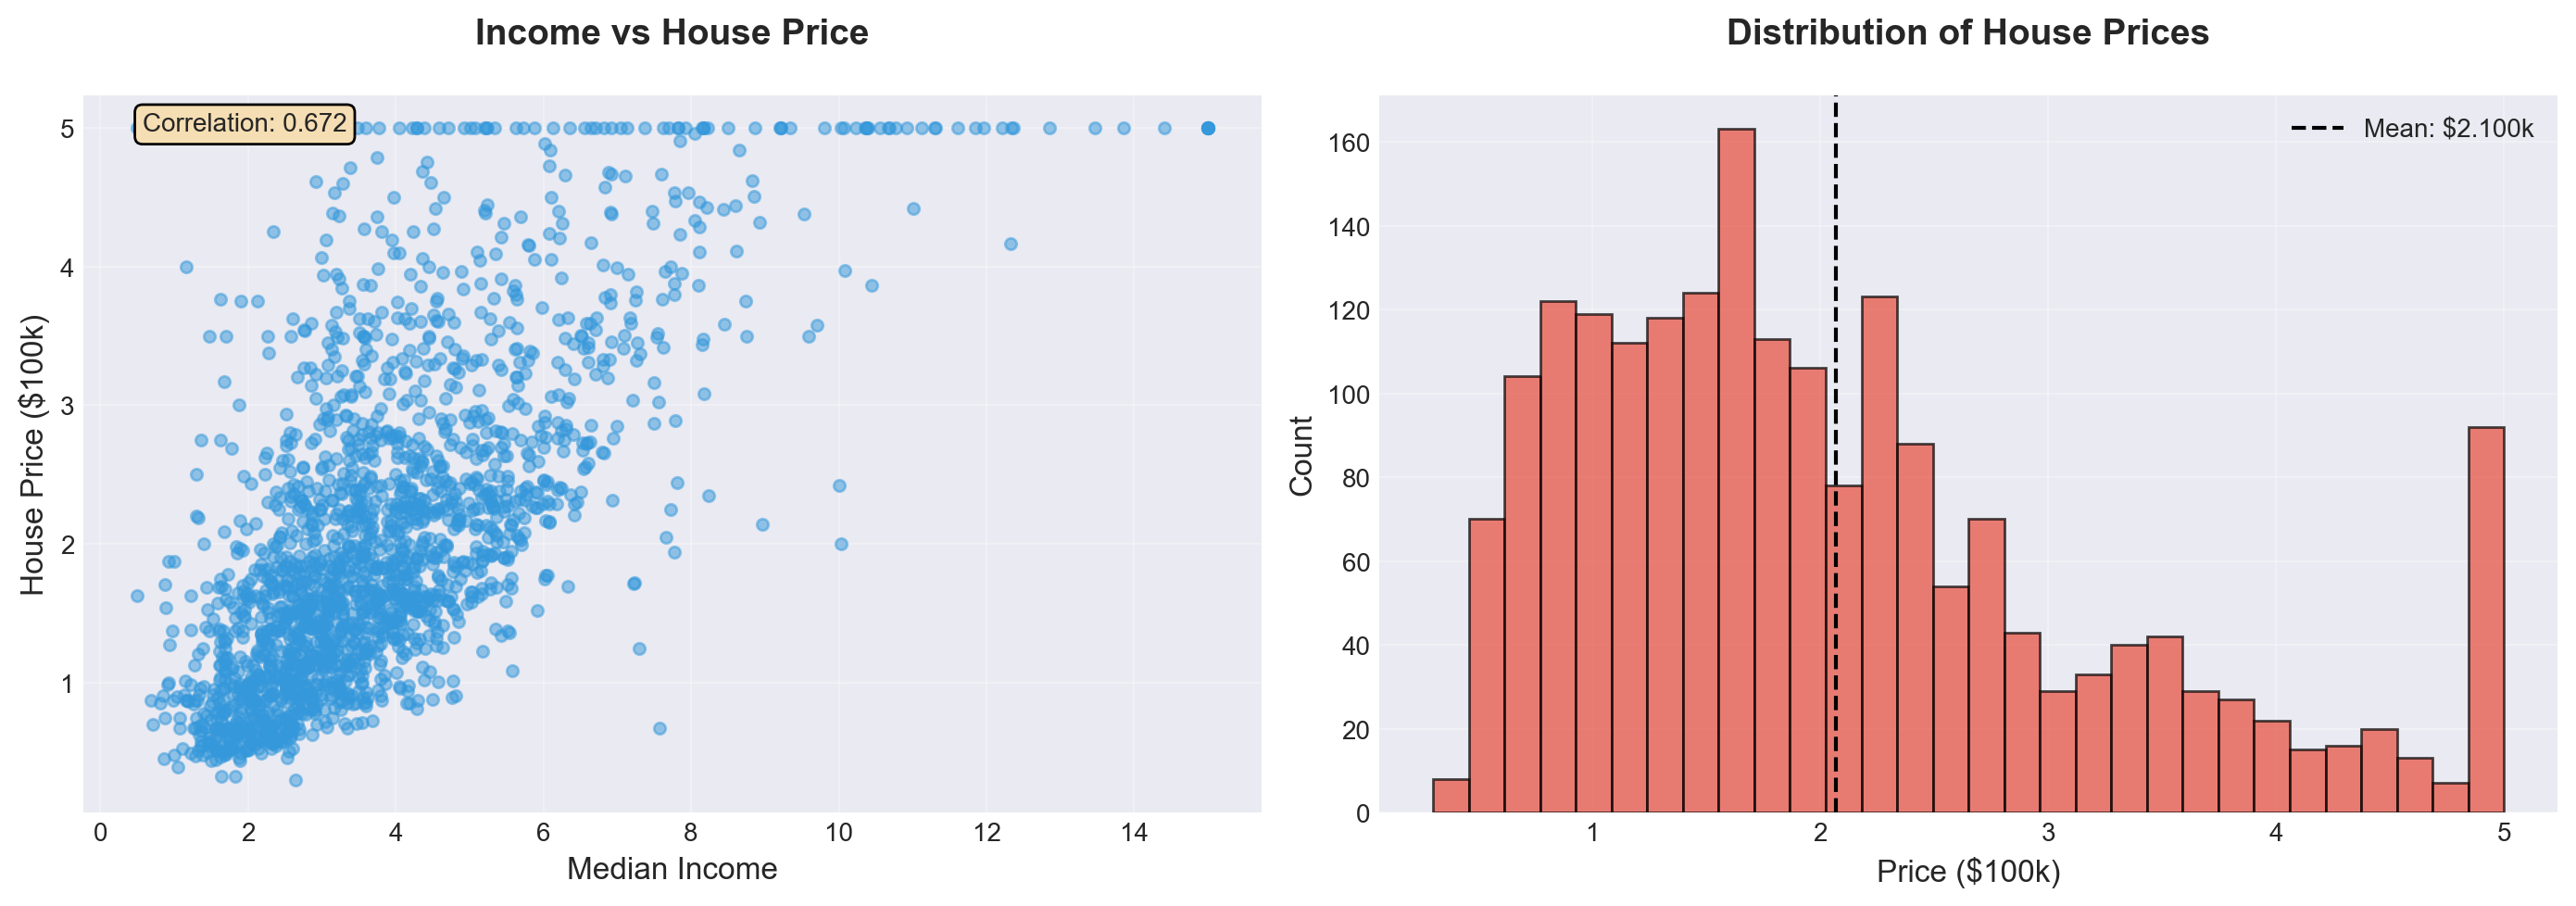

In [48]:
# Visualize the income-price relationship
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw data scatter plot
axes[0].scatter(X_raw, y_raw, alpha=0.5, s=20, color=COLORS['primary'])
style_plot(axes[0], 'Income vs House Price', 'Median Income', 'House Price ($100k)')
axes[0].text(0.05, 0.95, f"Correlation: {np.corrcoef(X_raw.flatten(), y_raw)[0,1]:.3f}", 
            transform=axes[0].transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))

# Distribution of target variable
axes[1].hist(y_raw, bins=30, color=COLORS['secondary'], alpha=0.7, edgecolor='black')
style_plot(axes[1], 'Distribution of House Prices', 'Price ($100k)', 'Count')
axes[1].axvline(y_raw.mean(), color='black', linestyle='--', 
               label=f'Mean: ${y_raw.mean():.1f}00k')
axes[1].legend()

plt.tight_layout()
plt.show()

### Critical: Data Preprocessing for Stable Optimization

Standardization is CRUCIAL for gradient descent. Without it, gradients can explode because they scale with the data values. With income ~3-5 and prices ~2-3, gradients become huge, causing the explosive behavior we see in unstandardized optimization.

**Why standardization prevents gradient explosion:**
- Original gradient magnitude: O(feature_scale × target_scale) = O(4 × 2) = O(8)
- With learning rate 0.1: parameter updates = 0.1 × 8 = 0.8 (huge!)
- After standardization: gradients = O(1), updates = 0.1 × 1 = 0.1 (reasonable)


In [49]:
# Properly standardize the data - this is critical!
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Standardize to mean=0, std=1
X_standardized = scaler_X.fit_transform(X_raw)
y_standardized = scaler_y.fit_transform(y_raw.reshape(-1, 1)).ravel()

print("After standardization:")
print(f"X_standardized: mean={X_standardized.mean():.4f}, std={X_standardized.std():.4f}")
print(f"y_standardized: mean={y_standardized.mean():.4f}, std={y_standardized.std():.4f}")

# Create train/test split from standardized data
X_train, X_test, y_train, y_test = train_test_split(
    X_standardized, y_standardized, test_size=0.2, random_state=42
)

# Verify training data is properly standardized
print("\nTraining data verification:")
print(f"X_train: mean={X_train.mean():.4f}, std={X_train.std():.4f}, shape={X_train.shape}")
print(f"y_train: mean={y_train.mean():.4f}, std={y_train.std():.4f}, shape={y_train.shape}")

After standardization:
X_standardized: mean=-0.0000, std=1.0000
y_standardized: mean=-0.0000, std=1.0000

Training data verification:
X_train: mean=-0.0178, std=0.9729, shape=(1600, 1)
y_train: mean=-0.0244, std=0.9938, shape=(1600,)


## Part 3: Building Intuition - The "Best Line" Game

### What Makes a Line "Best"?

Before diving into mathematics, let's build intuition. A line has two parameters: slope (weight) and intercept (bias). The "best" line minimizes the total squared error between predictions and actual values.

**Core concepts:**
- **Parameters**: What we can control (w, b)
- **Predictions**: What our model outputs (ŷ = wx + b)
- **Loss**: How wrong we are (MSE = average squared error)
- **Optimization**: Finding parameters that minimize loss

This manual process will help you appreciate what gradient descent automates.


### Interactive Line Fitting

This interactive tool lets you manually adjust parameters and see the effect on loss. Try to find the minimum - it's harder than it looks! This experience will help you understand why we need algorithmic optimization.


In [50]:
class InteractiveLineFitter:
    """Interactive tool for manual line fitting"""
    
    def __init__(self, X, y):
        # Ensure data is 1D and properly shaped
        self.X = X.flatten() if X.ndim > 1 else X
        self.y = y.flatten() if y.ndim > 1 else y
        self.history = {'w': [], 'b': [], 'loss': []}
        self.best_loss = float('inf')
        self.best_params = {'w': 0, 'b': 0}
        
    def calculate_loss(self, w, b):
        """Calculate Mean Squared Error"""
        predictions = self.X * w + b
        mse = np.mean((predictions - self.y) ** 2)
        return mse
    
    def update_visualization(self, w, b):
        """Update the visualization with current parameters"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Left: Data and current line
        ax1.scatter(self.X, self.y, alpha=0.3, s=30, color=COLORS['primary'])
        
        x_range = np.linspace(self.X.min(), self.X.max(), 100)
        y_pred_line = x_range * w + b
        ax1.plot(x_range, y_pred_line, 'r-', linewidth=3, 
                label=f'y = {w:.2f}x + {b:.2f}')
        
        # Show residuals for a subset of points
        predictions = self.X * w + b
        for i in range(0, min(len(self.X), 100), 10):
            ax1.plot([self.X[i], self.X[i]], 
                    [self.y[i], predictions[i]], 
                    'gray', alpha=0.3, linewidth=1)
        
        loss = self.calculate_loss(w, b)
        
        # Update history BEFORE plotting
        self.history['w'].append(w)
        self.history['b'].append(b)
        self.history['loss'].append(loss)
        
        style_plot(ax1, f'Current Loss: {loss:.4f}', 
                  'Income (scaled)', 'Price (scaled)')
        ax1.legend()
        
        # Right: Loss history - Fixed plotting
        if len(self.history['loss']) > 0:
            ax2.plot(range(len(self.history['loss'])), self.history['loss'], 
                    'b-', linewidth=2, marker='o', markersize=4)
            ax2.scatter(len(self.history['loss'])-1, loss, 
                       color='red', s=100, zorder=5, label='Current')
            
            # Add best point marker
            if loss < self.best_loss:
                self.best_loss = loss
                self.best_params = {'w': w, 'b': b}
            
            best_idx = self.history['loss'].index(self.best_loss)
            ax2.scatter(best_idx, self.best_loss, 
                       color='green', s=100, marker='*', zorder=5, label='Best')
            ax2.legend()
        
        style_plot(ax2, 'Your Optimization Journey', 'Attempt', 'MSE Loss')
        ax2.set_ylim(bottom=0)  # Set y-axis to start at 0
        
        plt.tight_layout()
        plt.show()
        
        # Print current status
        print(f"Attempt #{len(self.history['loss'])}: w={w:.3f}, b={b:.3f}, Loss={loss:.4f}")
        if loss <= self.best_loss:
            print("  ⭐ New best!")
        
        return loss

### Create the Interactive Widget

Use the sliders to adjust the weight and bias. Watch how the loss changes. Can you find the minimum? Notice how changes in weight have different effects than changes in bias.

**Things to observe:**
- Small parameter changes can cause large loss changes
- The loss can increase in some directions and decrease in others
- Finding the exact minimum manually is difficult
- You naturally follow the gradient (move toward lower loss)

In [51]:
# Create the interactive widget with properly standardized data
fitter = InteractiveLineFitter(X_train, y_train)

print("INTERACTIVE LINE FITTER")
print("="*50)
print("Instructions:")
print("1. Adjust the sliders to change the line")
print("2. Try to minimize the loss")
print("3. Watch your progress on the right")
print("="*50)

@interact(
    w=widgets.FloatSlider(value=0.0, min=-2.0, max=2.0, step=0.01,
                         description='Weight (w):', style={'description_width': 'initial'}),
    b=widgets.FloatSlider(value=0.0, min=-2.0, max=2.0, step=0.01,
                         description='Bias (b):', style={'description_width': 'initial'})
)
def manual_fit(w=0.0, b=0.0):
    loss = fitter.update_visualization(w, b)
    
    if loss < 0.5:
        print("Excellent! You've found a good fit!")
    elif loss < 1.0:
        print("Good progress! Can you get the loss below 0.5?")
    else:
        print("Keep adjusting - small changes can make big differences!")

INTERACTIVE LINE FITTER
Instructions:
1. Adjust the sliders to change the line
2. Try to minimize the loss
3. Watch your progress on the right


interactive(children=(FloatSlider(value=0.0, description='Weight (w):', max=2.0, min=-2.0, step=0.01, style=Sl…

### The Loss Landscape

The loss landscape shows the error for every possible combination of parameters. This visualization is key to understanding optimization - we're trying to find the lowest point in this landscape.

**Key insights from the landscape:**
- **Convexity**: Linear regression has a bowl-shaped loss surface
- **Global minimum**: Exactly one lowest point (no local traps)
- **Gradient direction**: Always points toward lower loss
- **Contour lines**: Show paths of equal loss

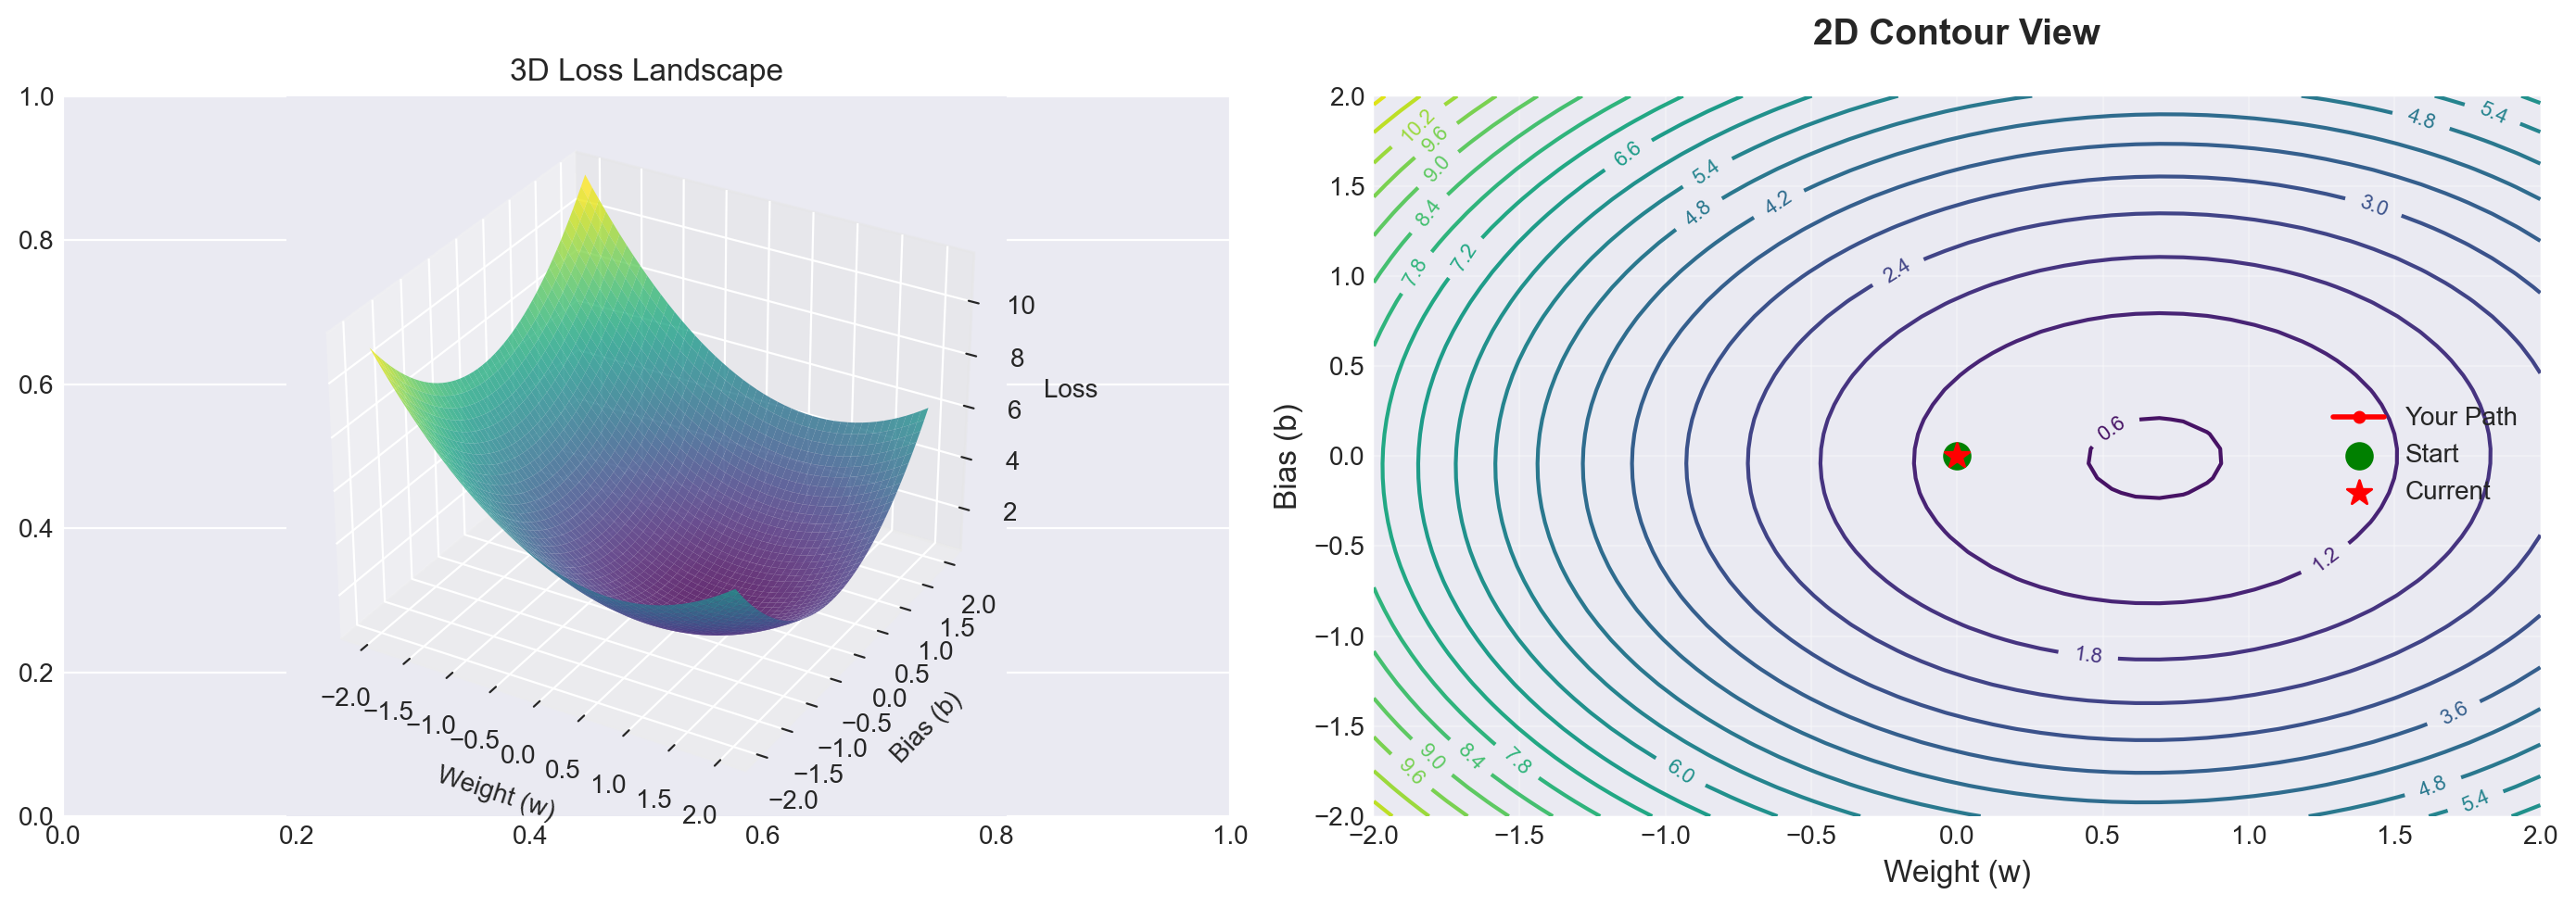


Optimal parameters:
   Weight (w) = 0.694
   Bias (b) = -0.041
   Minimum loss = 0.5504


In [52]:
def visualize_loss_landscape():
    """Create visualization of the loss surface"""
    
    # Create parameter grid
    w_range = np.linspace(-2, 2, 50)
    b_range = np.linspace(-2, 2, 50)
    W, B = np.meshgrid(w_range, b_range)
    
    # Calculate loss for each parameter combination
    Z = np.zeros_like(W)
    for i in range(50):
        for j in range(50):
            predictions = X_train.flatten() * W[i, j] + B[i, j]
            Z[i, j] = np.mean((predictions - y_train.flatten()) ** 2)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 3D surface plot
    ax1 = fig.add_subplot(121, projection='3d')
    surf = ax1.plot_surface(W, B, Z, cmap='viridis', alpha=0.8)
    ax1.set_xlabel('Weight (w)')
    ax1.set_ylabel('Bias (b)')
    ax1.set_zlabel('Loss')
    ax1.set_title('3D Loss Landscape')
    
    # 2D contour plot
    contour = ax2.contour(W, B, Z, levels=20, cmap='viridis')
    ax2.clabel(contour, inline=True, fontsize=8)
    
    # Add manual optimization path if available
    if len(fitter.history['w']) > 0:
        ax2.plot(fitter.history['w'], fitter.history['b'], 'r.-', 
                linewidth=2, markersize=8, label='Your Path')
        ax2.scatter(fitter.history['w'][0], fitter.history['b'][0], 
                   color='green', s=100, marker='o', label='Start')
        ax2.scatter(fitter.history['w'][-1], fitter.history['b'][-1], 
                   color='red', s=100, marker='*', label='Current')
    
    style_plot(ax2, '2D Contour View', 'Weight (w)', 'Bias (b)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal point
    min_idx = np.unravel_index(Z.argmin(), Z.shape)
    optimal_w = W[min_idx]
    optimal_b = B[min_idx]
    optimal_loss = Z[min_idx]
    
    print(f"\nOptimal parameters:")
    print(f"   Weight (w) = {optimal_w:.3f}")
    print(f"   Bias (b) = {optimal_b:.3f}")
    print(f"   Minimum loss = {optimal_loss:.4f}")

visualize_loss_landscape()

### Key Insights from Manual Optimization

Manual optimization teaches us several crucial lessons that motivate automatic methods:

1. **The Loss Surface is Convex**: For linear regression, there's exactly one global minimum - no local traps to worry about.

2. **Gradients Point Downhill**: The direction of steepest descent always leads toward lower loss.

3. **Manual Optimization is Tedious**: Even with just 2 parameters, finding the exact optimum is challenging. Imagine doing this for millions of parameters!

4. **Systematic Approach Needed**: We need an algorithm that can automatically follow the gradient to the minimum.


## Part 4: Gradient Descent - The Mathematics

### The Core Idea

Gradient descent automates what you did manually: it calculates which direction reduces the loss most (the gradient) and takes a small step in that direction. Repeat until convergence.

**The algorithm in three steps:**
1. **Calculate gradient**: Find direction of steepest increase
2. **Step opposite**: Move in negative gradient direction  
3. **Repeat**: Continue until gradients become very small

The learning rate controls step size - too large and you overshoot, too small and convergence is slow.


### Mathematical Formulation

For linear regression, we can derive the exact gradient formulas using calculus. These formulas tell us how the loss changes with respect to each parameter.

**Model**: ŷ = wx + b

**Loss Function**: L(w, b) = (1/n)Σ(yᵢ - (wxᵢ + b))²

**Gradients** (via chain rule):
- ∂L/∂w = (2/n)Σxᵢ(wxᵢ + b - yᵢ)
- ∂L/∂b = (2/n)Σ(wxᵢ + b - yᵢ)

**Update Rule**:
- w_new = w_old - α(∂L/∂w)
- b_new = b_old - α(∂L/∂b)

Where α (alpha) is the learning rate.

### Implementing Gradient Descent from Scratch

Let's implement these equations in code. This implementation is the foundation of all modern deep learning - the same principles scale to billions of parameters.

**Implementation insights:**
- Gradients are just derivatives evaluated at current parameters
- The learning rate is crucial - it's a hyperparameter we must tune
- We track history for visualization and debugging
- Convergence happens when gradients become very small

In [53]:
class ManualGradientDescent:
    """Gradient Descent implemented from scratch with stability features"""
    
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.w = 0.0  # Initialize weight
        self.b = 0.0  # Initialize bias
        self.history = {
            'w': [], 'b': [], 'loss': [], 
            'grad_w': [], 'grad_b': []
        }
    
    def calculate_gradients(self, X, y):
        """Calculate gradients of the loss with respect to w and b"""
        # Ensure 1D arrays
        X = X.flatten() if X.ndim > 1 else X
        y = y.flatten() if y.ndim > 1 else y
        n = len(X)
        
        # Forward pass: make predictions
        predictions = X * self.w + self.b
        
        # Calculate errors
        errors = predictions - y
        
        # Calculate gradients using our derived formulas
        grad_w = (2/n) * np.sum(X * errors)
        grad_b = (2/n) * np.sum(errors)
        
        # Add gradient clipping for stability
        max_grad_norm = 10.0
        grad_norm = np.sqrt(grad_w**2 + grad_b**2)
        if grad_norm > max_grad_norm:
            grad_w = grad_w * max_grad_norm / grad_norm
            grad_b = grad_b * max_grad_norm / grad_norm
        
        return grad_w, grad_b
    
    def calculate_loss(self, X, y):
        """Calculate Mean Squared Error"""
        X = X.flatten() if X.ndim > 1 else X
        y = y.flatten() if y.ndim > 1 else y
        
        predictions = X * self.w + self.b
        mse = np.mean((predictions - y) ** 2)
        return mse
    
    def step(self, X, y):
        """Perform one gradient descent step"""
        # 1. Calculate gradients
        grad_w, grad_b = self.calculate_gradients(X, y)
        
        # 2. Update parameters (gradient descent rule)
        self.w = self.w - self.learning_rate * grad_w
        self.b = self.b - self.learning_rate * grad_b
        
        # 3. Calculate new loss
        loss = self.calculate_loss(X, y)
        
        # 4. Store history for visualization
        self.history['w'].append(self.w)
        self.history['b'].append(self.b)
        self.history['loss'].append(loss)
        self.history['grad_w'].append(grad_w)
        self.history['grad_b'].append(grad_b)
        
        return loss, grad_w, grad_b
    
    def fit(self, X, y, epochs=100, verbose=True):
        """Train the model using gradient descent"""
        # Verify data is standardized
        X_mean = np.mean(X)
        X_std = np.std(X)
        y_mean = np.mean(y)
        y_std = np.std(y)
        
        if abs(X_mean) > 0.1 or abs(X_std - 1.0) > 0.2:
            print("⚠️ WARNING: Input data doesn't appear to be standardized!")
            print(f"   X mean={X_mean:.3f} (should be ~0), std={X_std:.3f} (should be ~1)")
            print("   This may cause training to diverge!")
        
        print("Starting Gradient Descent")
        print(f"   Learning rate: {self.learning_rate}")
        print(f"   Initial parameters: w={self.w:.3f}, b={self.b:.3f}")
        print("="*50)
        
        for epoch in range(epochs):
            loss, grad_w, grad_b = self.step(X, y)
            
            # Check for convergence issues
            if np.isnan(loss) or np.isinf(loss) or loss > 1e10:
                print(f"\n❌ Training diverged at epoch {epoch}!")
                print(f"   Loss exploded to: {loss:.2e}")
                print("\nPossible causes:")
                print("   1. Data not standardized (most common)")
                print("   2. Learning rate too high")
                print("   3. Numerical instability")
                break
            
            if verbose and epoch % 10 == 0:
                grad_norm = np.sqrt(grad_w**2 + grad_b**2)
                print(f"Epoch {epoch:3d}: Loss = {loss:.4f}, "
                      f"w = {self.w:6.3f}, b = {self.b:6.3f}, "
                      f"||∇|| = {grad_norm:.4f}")
        
        if loss < 1e10:  # Only print success if didn't diverge
            print("="*50)
            print("✅ Training complete!")
            print(f"   Final parameters: w={self.w:.3f}, b={self.b:.3f}")
            print(f"   Final loss: {self.history['loss'][-1]:.4f}")

### Training with Gradient Descent

Watch how gradient descent automatically finds the optimal parameters. Notice how the loss decreases rapidly at first, then more slowly as we approach the minimum.

In [54]:
# Initialize and train gradient descent with standardized data
# Using a more conservative learning rate for stability
gd = ManualGradientDescent(learning_rate=0.05)  # Reduced from 0.1
gd.fit(X_train, y_train, epochs=50)

Starting Gradient Descent
   Learning rate: 0.05
   Initial parameters: w=0.000, b=0.000
Epoch   0: Loss = 0.9091, w =  0.064, b = -0.002, ||∇|| = 1.2900
Epoch  10: Loss = 0.5985, w =  0.453, b = -0.013, ||∇|| = 0.4765
Epoch  20: Loss = 0.5561, w =  0.596, b = -0.014, ||∇|| = 0.1762
Epoch  30: Loss = 0.5503, w =  0.649, b = -0.014, ||∇|| = 0.0652
Epoch  40: Loss = 0.5495, w =  0.669, b = -0.013, ||∇|| = 0.0241
✅ Training complete!
   Final parameters: w=0.676, b=-0.013
   Final loss: 0.5494


### Visualizing the Optimization Journey

This visualization shows three perspectives on the same optimization process. Understanding these different views helps build intuition about what gradient descent is doing.

**What to observe:**
- **Loss curve**: Exponential decay is typical for convex problems
- **Parameter path**: Gradient descent takes a direct path to minimum
- **Gradient magnitude**: Decreases as we approach the optimum

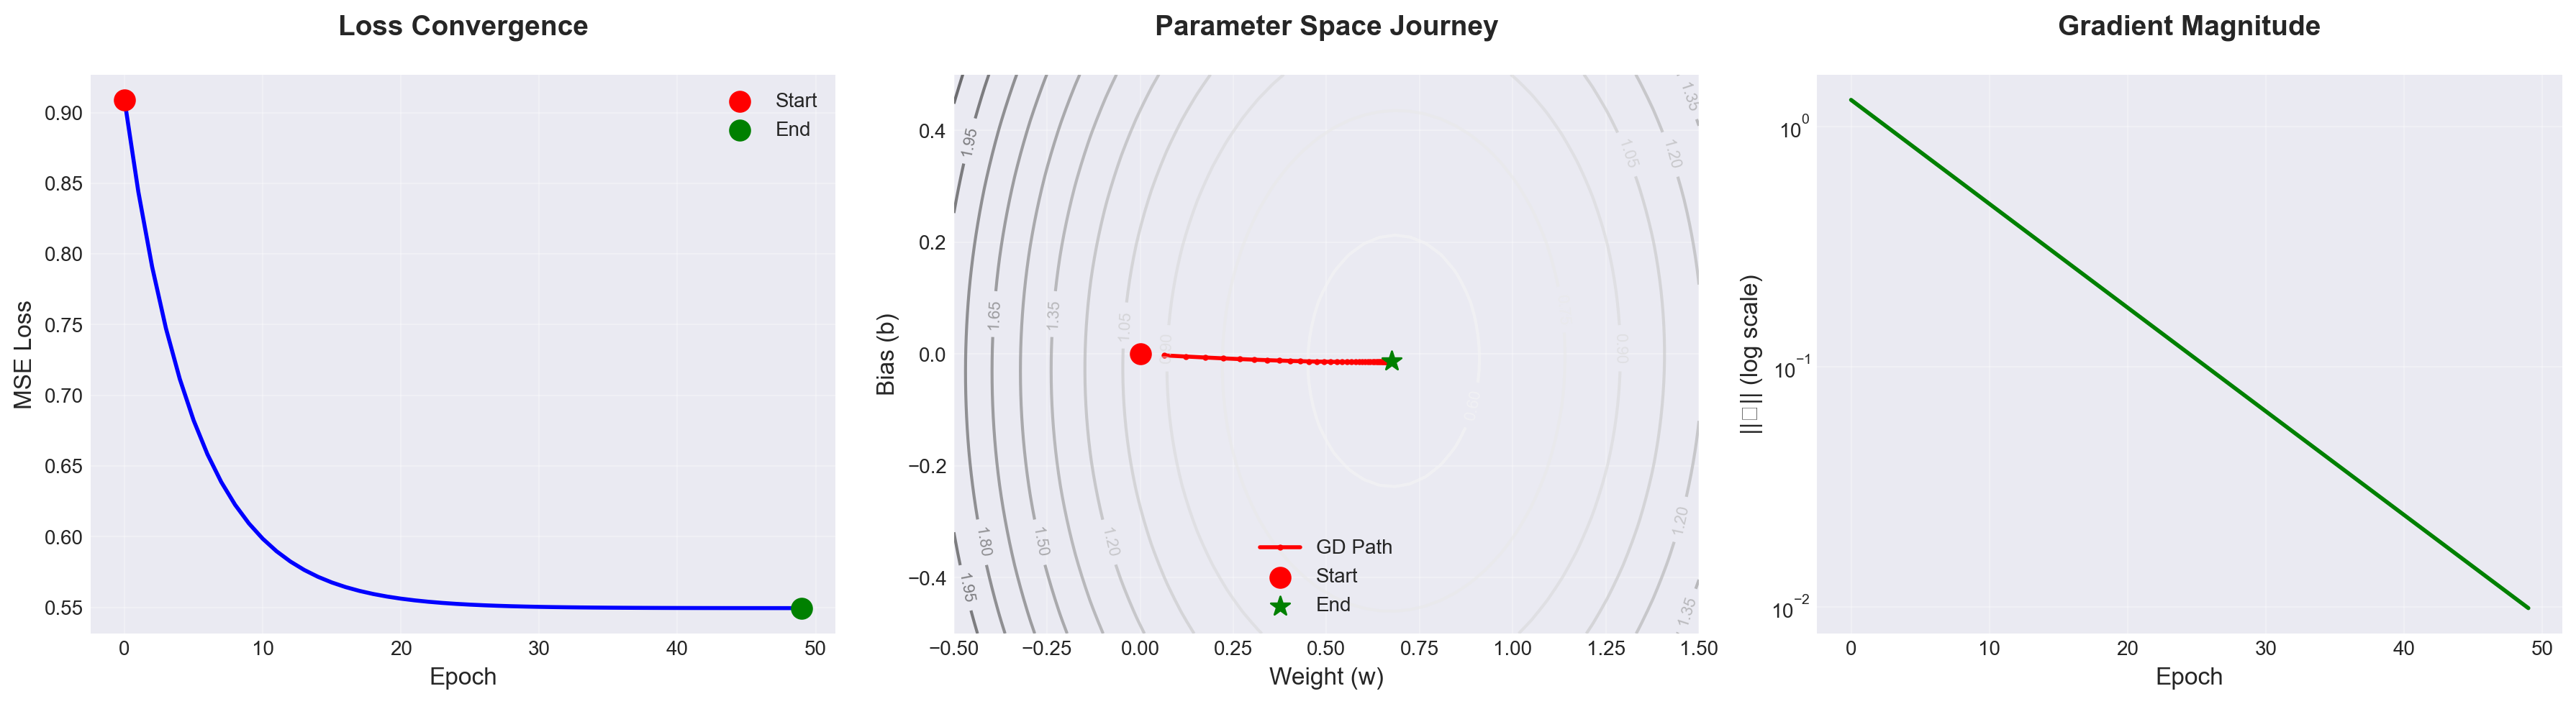

In [55]:
def visualize_gd_journey(gd_model, X, y):
    """Visualize gradient descent optimization process"""
    
    # Ensure 1D arrays
    X = X.flatten() if X.ndim > 1 else X
    y = y.flatten() if y.ndim > 1 else y
    
    fig = plt.figure(figsize=(18, 5))
    
    # 1. Loss convergence
    ax1 = fig.add_subplot(131)
    ax1.plot(gd_model.history['loss'], 'b-', linewidth=2)
    ax1.scatter([0], [gd_model.history['loss'][0]], 
               color='red', s=100, zorder=5, label='Start')
    ax1.scatter([len(gd_model.history['loss'])-1], 
               [gd_model.history['loss'][-1]], 
               color='green', s=100, zorder=5, label='End')
    style_plot(ax1, 'Loss Convergence', 'Epoch', 'MSE Loss')
    ax1.legend()
    
    # 2. Parameter space journey
    ax2 = fig.add_subplot(132)
    
    # Create contour plot
    w_range = np.linspace(-0.5, 1.5, 50)
    b_range = np.linspace(-0.5, 0.5, 50)
    W, B = np.meshgrid(w_range, b_range)
    Z = np.zeros_like(W)
    
    for i in range(50):
        for j in range(50):
            predictions = X * W[i, j] + B[i, j]
            Z[i, j] = np.mean((predictions - y) ** 2)
    
    contour = ax2.contour(W, B, Z, levels=15, alpha=0.6)
    ax2.clabel(contour, inline=True, fontsize=8)
    
    # Plot optimization path
    ax2.plot(gd_model.history['w'], gd_model.history['b'], 
            'r.-', linewidth=2, markersize=4, label='GD Path')
    ax2.scatter([0], [0], color='red', s=100, marker='o', zorder=5, label='Start')
    ax2.scatter([gd_model.history['w'][-1]], [gd_model.history['b'][-1]], 
               color='green', s=100, marker='*', zorder=5, label='End')
    
    style_plot(ax2, 'Parameter Space Journey', 'Weight (w)', 'Bias (b)')
    ax2.legend()
    
    # 3. Gradient magnitude over time
    ax3 = fig.add_subplot(133)
    grad_norms = [np.sqrt(gw**2 + gb**2) for gw, gb in 
                  zip(gd_model.history['grad_w'], gd_model.history['grad_b'])]
    ax3.semilogy(grad_norms, 'g-', linewidth=2)
    style_plot(ax3, 'Gradient Magnitude', 'Epoch', '||∇|| (log scale)')
    
    plt.tight_layout()
    plt.show()

visualize_gd_journey(gd, X_train, y_train)

### The Effect of Learning Rate

Learning rate is the most critical hyperparameter in gradient descent. Too small and convergence is painfully slow. Too large and you might diverge. Let's see this in action.

**Learning rate insights:**
- Controls the step size in parameter updates
- Must be small enough to not overshoot
- Must be large enough to converge in reasonable time
- Problem-dependent - no universal best value
- Often decreased during training (learning rate scheduling)

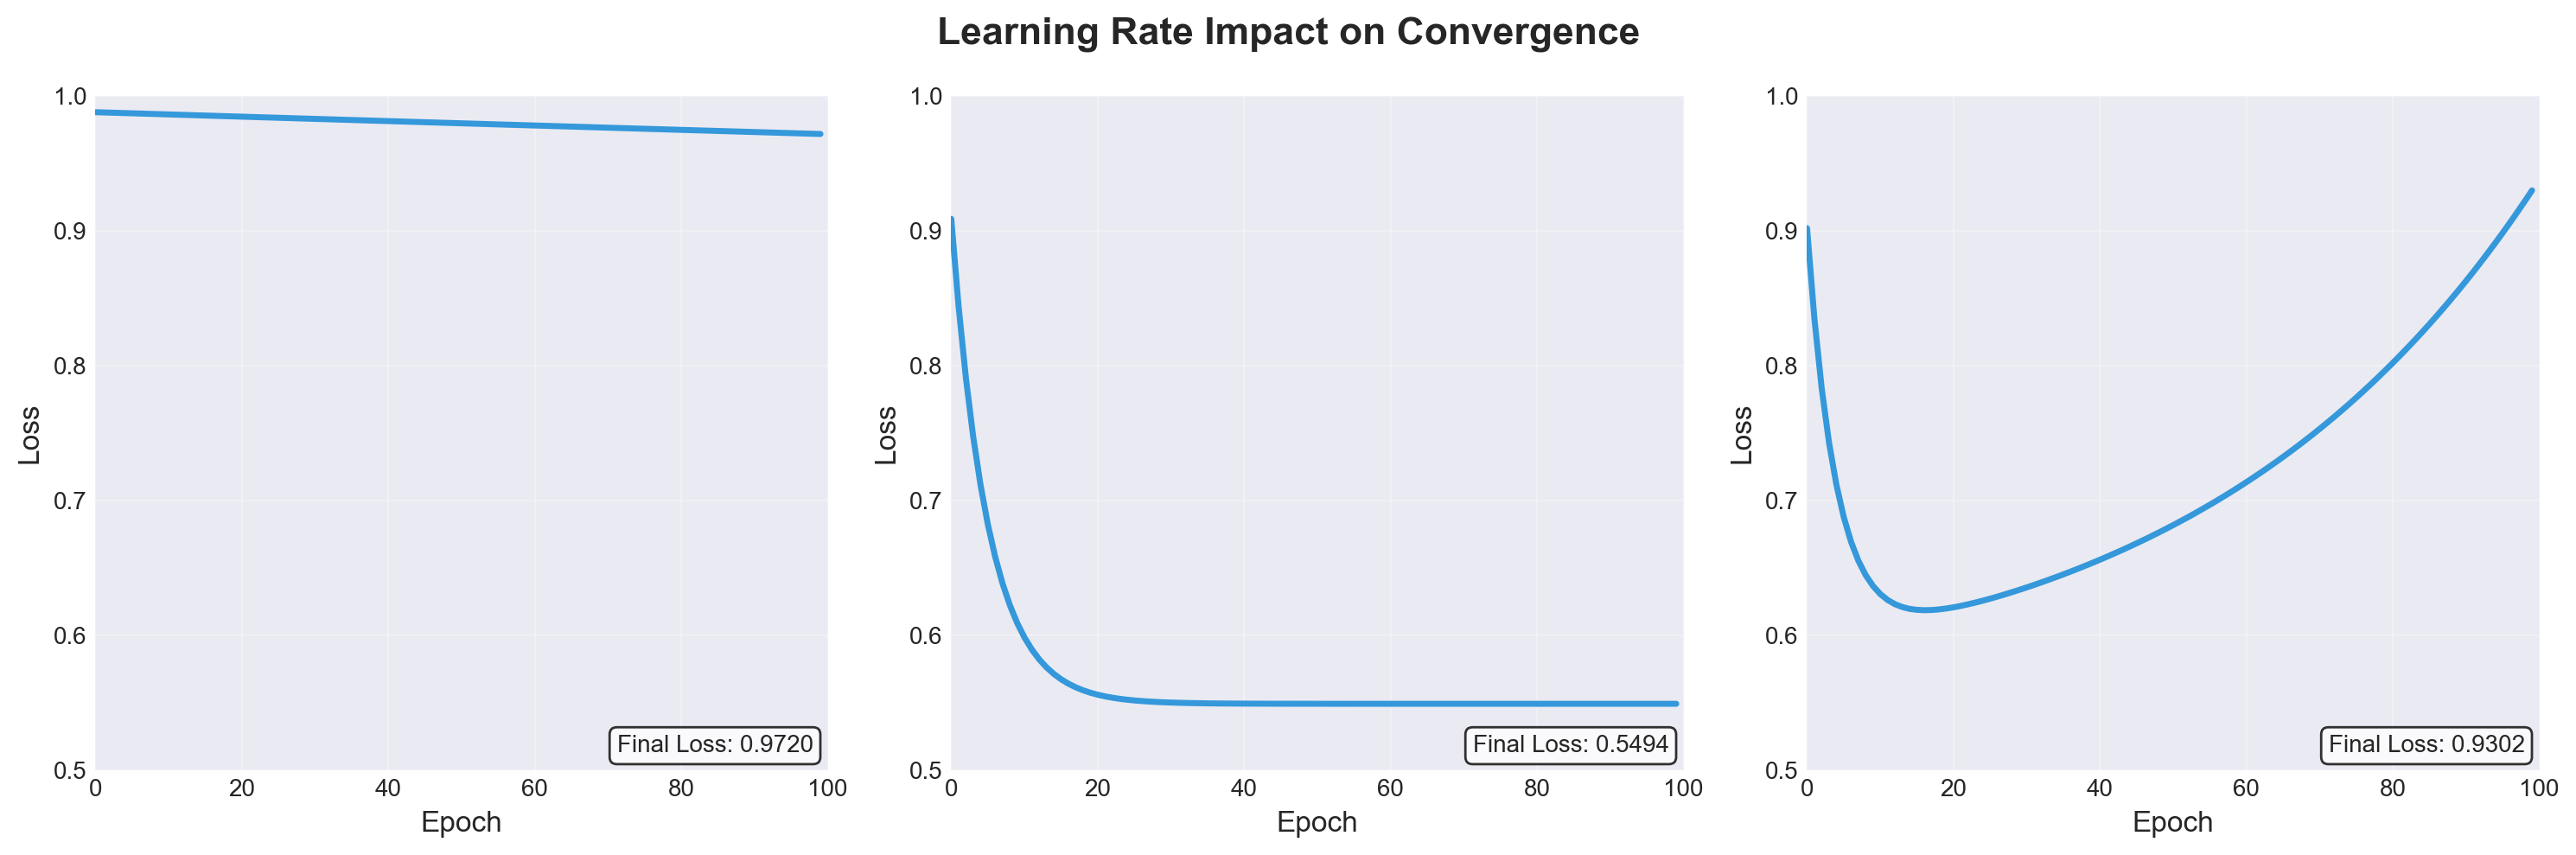

In [56]:
def compare_learning_rates():
    """Compare different learning rates on standardized data"""
    
    # Three rates: too small, just right, too large
    learning_rates = [0.0001, 0.05, 1]
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Learning Rate Impact on Convergence', fontsize=16, fontweight='bold')
    
    for idx, lr in enumerate(learning_rates):
        ax = axes[idx]
        
        # Train with different learning rate
        gd_temp = ManualGradientDescent(learning_rate=lr)
        
        # Run for same number of epochs
        converged = True
        max_epochs = 100
        for epoch in range(max_epochs):
            loss, _, _ = gd_temp.step(X_train, y_train)
            
            # Check for divergence
            if np.isnan(loss) or np.isinf(loss) or loss > 10:
                converged = False
                break
        
        # Plot results
        if converged and len(gd_temp.history['loss']) > 0:
            ax.plot(gd_temp.history['loss'], linewidth=2.5, color=COLORS['primary'])
            
            # Set consistent y-axis range
            ax.set_ylim(0.5, 1.0)
            
            # Add annotations based on performance
            final_loss = gd_temp.history['loss'][-1]
            
            if lr == 0.001:
                ax.set_title(f'LR = {lr} (Too Small)', fontweight='bold', color='orange')
                ax.text(0.5, 0.7, 'SLOW\nCONVERGENCE', 
                       transform=ax.transAxes, ha='center', va='center',
                       fontsize=16, color='orange', alpha=0.7, fontweight='bold')
            elif lr == 0.05:
                ax.set_title(f'LR = {lr} (Just Right)', fontweight='bold', color='green')

            # Add final loss in corner
            ax.text(0.98, 0.02, f'Final Loss: {final_loss:.4f}', 
                    transform=ax.transAxes, ha='right', va='bottom',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            # Diverged case
            ax.set_title(f'LR = {lr} (Too Large)', color='red', fontweight='bold')
            
            # Plot what we have before divergence
            if len(gd_temp.history['loss']) > 0:
                valid_losses = [l for l in gd_temp.history['loss'] if l < 10]
                if valid_losses:
                    ax.plot(range(len(valid_losses)), valid_losses, 
                           linewidth=2.5, color='red')
            
            ax.set_ylim(0.5, 10)
            ax.set_yscale('log')
            
        
        style_plot(ax, '', 'Epoch', 'Loss')
        ax.set_xlim(0, max_epochs)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

compare_learning_rates()

## Part 5: Stochastic Gradient Descent Variants

### The Computational Challenge

Real datasets have millions of samples. Computing gradients on all data for each update becomes prohibitively expensive. SGD variants make different trade-offs between gradient accuracy and computational cost.

**Three approaches:**
1. **Batch GD**: Use all data - accurate but slow O(n)
2. **Stochastic GD**: Use one sample - fast but noisy O(1)  
3. **Mini-batch GD**: Use small batches - balanced O(b)

Mini-batch has become the standard because it:
- Provides smoother convergence than pure SGD
- Is much faster than batch GD
- Can leverage GPU parallelization
- Allows larger effective learning rates


### Implementing SGD Variants

This implementation shows how the three variants differ only in how they select data for gradient computation. The core gradient calculation remains the same.


In [57]:
class StochasticGradientDescent:
    """Implementation of SGD variants with stability features"""
    
    def __init__(self, learning_rate=0.01, batch_size=32, method='mini-batch'):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.method = method  # 'batch', 'stochastic', 'mini-batch'
        self.w = 0.0  # Initialize to zero for stability
        self.b = 0.0
        self.history = {'loss': [], 'epoch_loss': []}
    
    def get_batch(self, X, y):
        """Get a batch of data based on the method"""
        # Ensure 1D arrays
        X = X.flatten() if X.ndim > 1 else X
        y = y.flatten() if y.ndim > 1 else y
        n = len(X)
        
        if self.method == 'batch':
            return X, y
        elif self.method == 'stochastic':
            idx = np.random.randint(n)
            return X[idx:idx+1], y[idx:idx+1]
        else:  # mini-batch
            batch_indices = np.random.choice(n, min(self.batch_size, n), replace=False)
            return X[batch_indices], y[batch_indices]
    
    def train_epoch(self, X, y):
        """Train for one epoch"""
        # Ensure 1D arrays
        X = X.flatten() if X.ndim > 1 else X
        y = y.flatten() if y.ndim > 1 else y
        n = len(X)
        
        # Determine number of iterations
        if self.method == 'batch':
            n_iterations = 1
        elif self.method == 'stochastic':
            n_iterations = n
        else:  # mini-batch
            n_iterations = max(1, n // self.batch_size)
        
        epoch_losses = []
        
        for i in range(n_iterations):
            # Get batch
            X_batch, y_batch = self.get_batch(X, y)
            
            # Calculate gradients
            predictions = X_batch * self.w + self.b
            errors = predictions - y_batch
            grad_w = (2/len(X_batch)) * np.sum(X_batch * errors)
            grad_b = (2/len(X_batch)) * np.sum(errors)
            
            # Update parameters
            self.w -= self.learning_rate * grad_w
            self.b -= self.learning_rate * grad_b
            
            # Record batch loss
            batch_loss = np.mean(errors ** 2)
            epoch_losses.append(batch_loss)
        
        # Calculate full epoch loss on all data
        full_predictions = X * self.w + self.b
        epoch_loss = np.mean((full_predictions - y) ** 2)
        
        return epoch_loss, np.mean(epoch_losses) if epoch_losses else epoch_loss
    
    def fit(self, X, y, epochs=20):
        """Train the model"""
        print(f"\nTraining with {self.method} gradient descent")
        print(f"   Learning rate: {self.learning_rate}")
        if self.method == 'mini-batch':
            print(f"   Batch size: {self.batch_size}")
        
        for epoch in range(epochs):
            epoch_loss, _ = self.train_epoch(X, y)
            
            # Check for issues
            if np.isnan(epoch_loss) or np.isinf(epoch_loss):
                print(f"Training stopped at epoch {epoch} due to numerical issues")
                break
            
            self.history['epoch_loss'].append(epoch_loss)
            
            if epoch % 5 == 0:
                print(f"Epoch {epoch:3d}: Loss = {epoch_loss:.4f}")
        
        if self.history['epoch_loss']:
            print(f"Final loss: {self.history['epoch_loss'][-1]:.4f}")

### Comparing SGD Variants

Each variant requires different learning rates for stability. Batch can use larger learning rates because its gradients are accurate. Stochastic needs smaller rates due to noise.

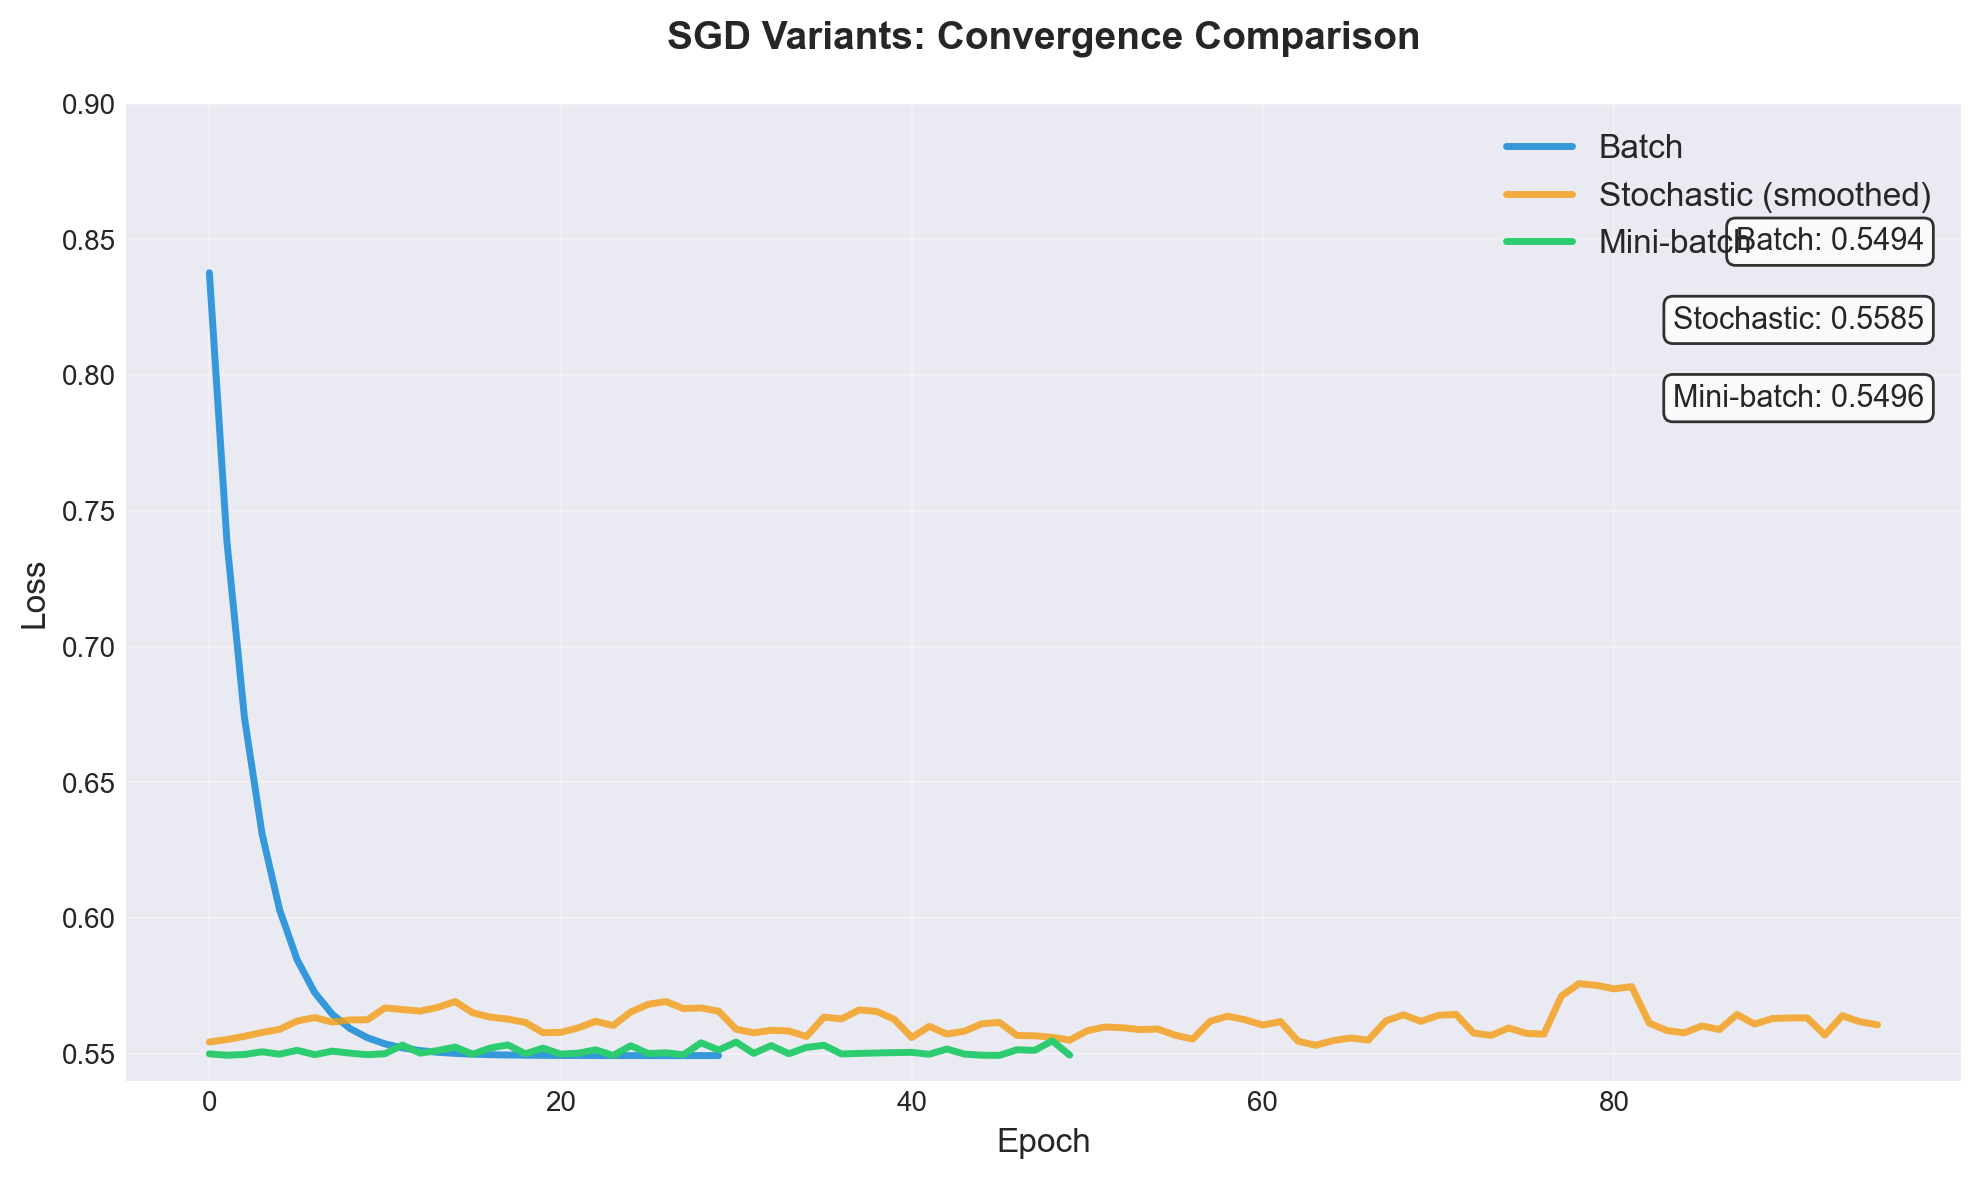

In [58]:
# Train models with different methods on standardized data
methods = ['batch', 'stochastic', 'mini-batch']
sgd_results = {}
training_info = {}

for method in methods:
    # Carefully tuned learning rates for each method
    if method == 'batch':
        lr = 0.1
        epochs = 30
    elif method == 'mini-batch':
        lr = 0.05
        epochs = 50
    else:  # stochastic
        lr = 0.01
        epochs = 100  # More epochs for noisy stochastic
    
    model = StochasticGradientDescent(
        learning_rate=lr, 
        batch_size=32, 
        method=method
    )
    
    # Train silently
    for epoch in range(epochs):
        epoch_loss, _ = model.train_epoch(X_train, y_train)
        model.history['epoch_loss'].append(epoch_loss)
    
    sgd_results[method] = model
    training_info[method] = {'lr': lr, 'epochs': epochs, 'final_loss': model.history['epoch_loss'][-1]}

# Simple visualization focusing on convergence
def visualize_sgd_comparison_simple(results):
    """Simple SGD convergence comparison"""
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = {'batch': COLORS['primary'], 
              'mini-batch': COLORS['success'], 
              'stochastic': COLORS['warning']}
    
    for method, model in results.items():
        if model.history['epoch_loss']:
            if method == 'stochastic':
                # Apply moving average for clearer visualization
                window = 5
                smoothed = np.convolve(model.history['epoch_loss'], 
                                      np.ones(window)/window, mode='valid')
                ax.plot(smoothed, linewidth=2.5, label=f'{method.capitalize()} (smoothed)',
                       color=colors[method], alpha=0.8)
            else:
                ax.plot(model.history['epoch_loss'], 
                       linewidth=2.5, label=method.capitalize(),
                       color=colors[method])
    
    # Add final loss annotations
    for i, (method, model) in enumerate(results.items()):
        final_loss = model.history['epoch_loss'][-1]
        ax.text(0.98, 0.85 - i*0.08, f'{method.capitalize()}: {final_loss:.4f}',
                transform=ax.transAxes, fontsize=11,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                ha='right')
    
    style_plot(ax, 'SGD Variants: Convergence Comparison', 'Epoch', 'Loss')
    ax.legend(loc='upper right', fontsize=12)
    ax.set_ylim(0.54, 0.9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

visualize_sgd_comparison_simple(sgd_results)

### Key Insights from SGD Comparison

**Batch Gradient Descent**
- Smooth convergence path
- Guaranteed to find local minimum (with proper learning rate)
- Becomes impractical for large datasets
- Cannot escape shallow local minima (not an issue for convex problems)

**Stochastic Gradient Descent**
- Very fast iterations
- Noise can help escape local minima (important for neural networks)
- High variance makes convergence criteria tricky
- Final solution oscillates around minimum

**Mini-batch Gradient Descent**
- Industry standard for good reasons
- Leverages hardware parallelization (GPUs)
- Reduces noise while maintaining speed
- Allows stable training with reasonable learning rates

## Part 6: Debugging and Failure Analysis

### Common Failure Modes

Understanding how optimization fails is as important as knowing how it works. Let's explore the most common problems and their diagnostic signatures.

**The usual suspects:**
1. **Vanishing Gradients**: Gradients become too small to make progress
2. **Exploding Gradients**: Gradients grow exponentially, causing instability
3. **Poor Learning Rate**: Too high causes divergence, too low causes slow/no progress
4. **Bad Initialization**: Starting point makes optimization difficult or impossible


### Understanding Gradient Explosion

The gradient explosion we saw earlier happens when data isn't standardized. Here's why:

**With unstandardized data:**
- Income values: ~3-5 (thousands of dollars)
- Price values: ~2-3 (hundreds of thousands)
- Gradient w.r.t. weight: ∝ income × error ≈ 4 × 2 = 8
- With learning rate 0.1: weight_update = 0.1 × 8 = 0.8 (huge!)
- This causes predictions to overshoot dramatically
- Errors grow exponentially → gradient explosion

**With standardized data (mean=0, std=1):**
- All values: ~[-2, 2]
- Gradients: O(1)
- Updates: reasonable and stable

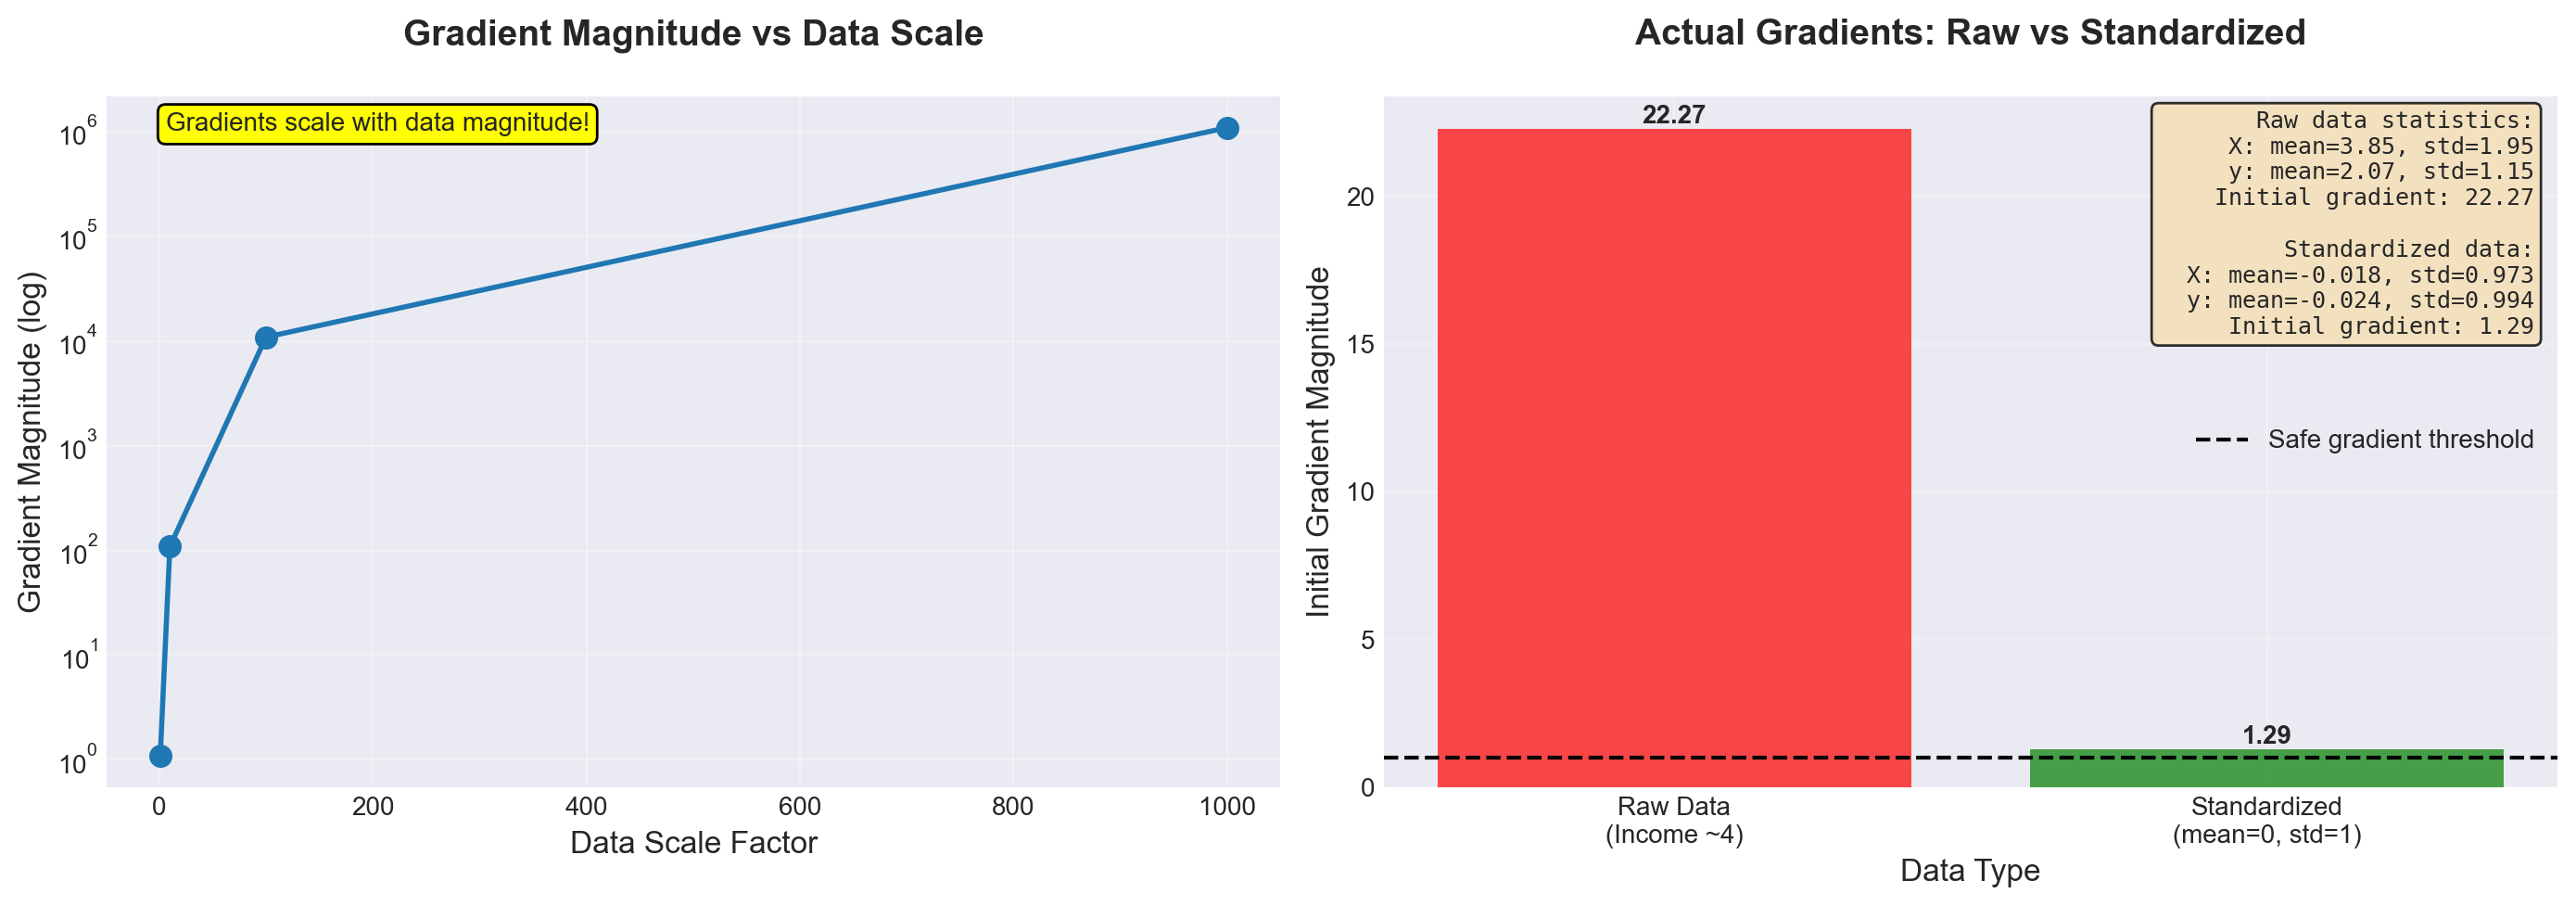

Key Insights:
1. Raw data gradient magnitude: 22.27 (DANGEROUS)
2. Standardized gradient magnitude: 1.29 (safe)
3. Reduction factor: 17.3x

Standardization keeps gradients O(1) regardless of data scale!


In [62]:
def demonstrate_standardization_importance():
    """Show why standardization prevents gradient explosion"""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Gradient magnitudes at different data scales
    income_scales = [1, 10, 100, 1000]
    gradient_magnitudes = []
    
    for scale in income_scales:
        # Simulate gradient calculation with realistic values
        np.random.seed(42)  # For reproducibility
        X_sim = np.random.randn(100) * scale
        y_sim = X_sim * 0.7 + np.random.randn(100) * scale * 0.3  # Linear relationship with noise
        
        # Calculate actual gradient at initialization (w=0, b=0)
        predictions = np.zeros_like(y_sim)  # Since w=0, b=0
        errors = predictions - y_sim
        grad_w = (2/len(X_sim)) * np.sum(X_sim * errors)
        grad_b = (2/len(X_sim)) * np.sum(errors)
        
        # Store gradient norm
        grad_norm = np.sqrt(grad_w**2 + grad_b**2)
        gradient_magnitudes.append(grad_norm)
    
    axes[0].semilogy(income_scales, gradient_magnitudes, 'o-', linewidth=2, markersize=8)
    style_plot(axes[0], 'Gradient Magnitude vs Data Scale', 
              'Data Scale Factor', 'Gradient Magnitude (log)')
    axes[0].text(0.05, 0.95, 'Gradients scale with data magnitude!', 
                transform=axes[0].transAxes, 
                bbox=dict(boxstyle='round', facecolor='yellow'))
    
    # Right: Compare actual gradients from our training data
    
    # Calculate gradient for raw (unstandardized) data
    np.random.seed(42)
    raw_sample_idx = np.random.choice(len(X_raw), min(100, len(X_raw)), replace=False)
    X_raw_sample = X_raw[raw_sample_idx].flatten()
    y_raw_sample = y_raw[raw_sample_idx]
    
    # Initial gradient (at w=0, b=0)
    predictions_raw = np.zeros_like(y_raw_sample)
    errors_raw = predictions_raw - y_raw_sample
    grad_w_raw = (2/len(X_raw_sample)) * np.sum(X_raw_sample * errors_raw)
    grad_b_raw = (2/len(X_raw_sample)) * np.sum(errors_raw)
    grad_norm_raw = np.sqrt(grad_w_raw**2 + grad_b_raw**2)
    
    # Calculate gradient for standardized data
    X_std_sample = X_train[:100].flatten()
    y_std_sample = y_train[:100]
    
    predictions_std = np.zeros_like(y_std_sample)
    errors_std = predictions_std - y_std_sample
    grad_w_std = (2/len(X_std_sample)) * np.sum(X_std_sample * errors_std)
    grad_b_std = (2/len(X_std_sample)) * np.sum(errors_std)
    grad_norm_std = np.sqrt(grad_w_std**2 + grad_b_std**2)
    
    # Plot comparison
    data_types = ['Raw Data\n(Income ~4)', 'Standardized\n(mean=0, std=1)']
    gradient_sizes = [grad_norm_raw, grad_norm_std]
    colors = ['red' if g > 2.0 else 'green' for g in gradient_sizes]
    
    bars = axes[1].bar(data_types, gradient_sizes, color=colors, alpha=0.7)
    axes[1].axhline(y=1.0, color='black', linestyle='--', 
                   label='Safe gradient threshold')
    style_plot(axes[1], 'Actual Gradients: Raw vs Standardized', 
              'Data Type', 'Initial Gradient Magnitude')
    axes[1].legend()
    
    # Add value labels on bars
    for bar, value in zip(bars, gradient_sizes):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # Add statistics text box
    stats_text = (f"Raw data statistics:\n"
                  f"  X: mean={X_raw.mean():.2f}, std={X_raw.std():.2f}\n"
                  f"  y: mean={y_raw.mean():.2f}, std={y_raw.std():.2f}\n"
                  f"  Initial gradient: {grad_norm_raw:.2f}\n\n"
                  f"Standardized data:\n"
                  f"  X: mean={X_train.mean():.3f}, std={X_train.std():.3f}\n"
                  f"  y: mean={y_train.mean():.3f}, std={y_train.std():.3f}\n"
                  f"  Initial gradient: {grad_norm_std:.2f}")
    
    axes[1].text(0.98, 0.98, stats_text, transform=axes[1].transAxes,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                verticalalignment='top', horizontalalignment='right',
                fontsize=9, family='monospace')
    
    plt.tight_layout()
    plt.show()
    
    print("Key Insights:")
    print(f"1. Raw data gradient magnitude: {grad_norm_raw:.2f} ({'DANGEROUS' if grad_norm_raw > 2 else 'safe'})")
    print(f"2. Standardized gradient magnitude: {grad_norm_std:.2f} ({'DANGEROUS' if grad_norm_std > 2 else 'safe'})")
    print(f"3. Reduction factor: {grad_norm_raw/grad_norm_std:.1f}x")
    print("\nStandardization keeps gradients O(1) regardless of data scale!")

demonstrate_standardization_importance()

### Gradient Flow Diagnostic Tool

A systematic diagnostic tool helps identify problems quickly. This tool analyzes training metrics to detect common failure patterns.

**Diagnostic approach:**
- Monitor gradient magnitudes over time
- Analyze loss curve patterns
- Check parameter update sizes
- Detect oscillations and plateaus

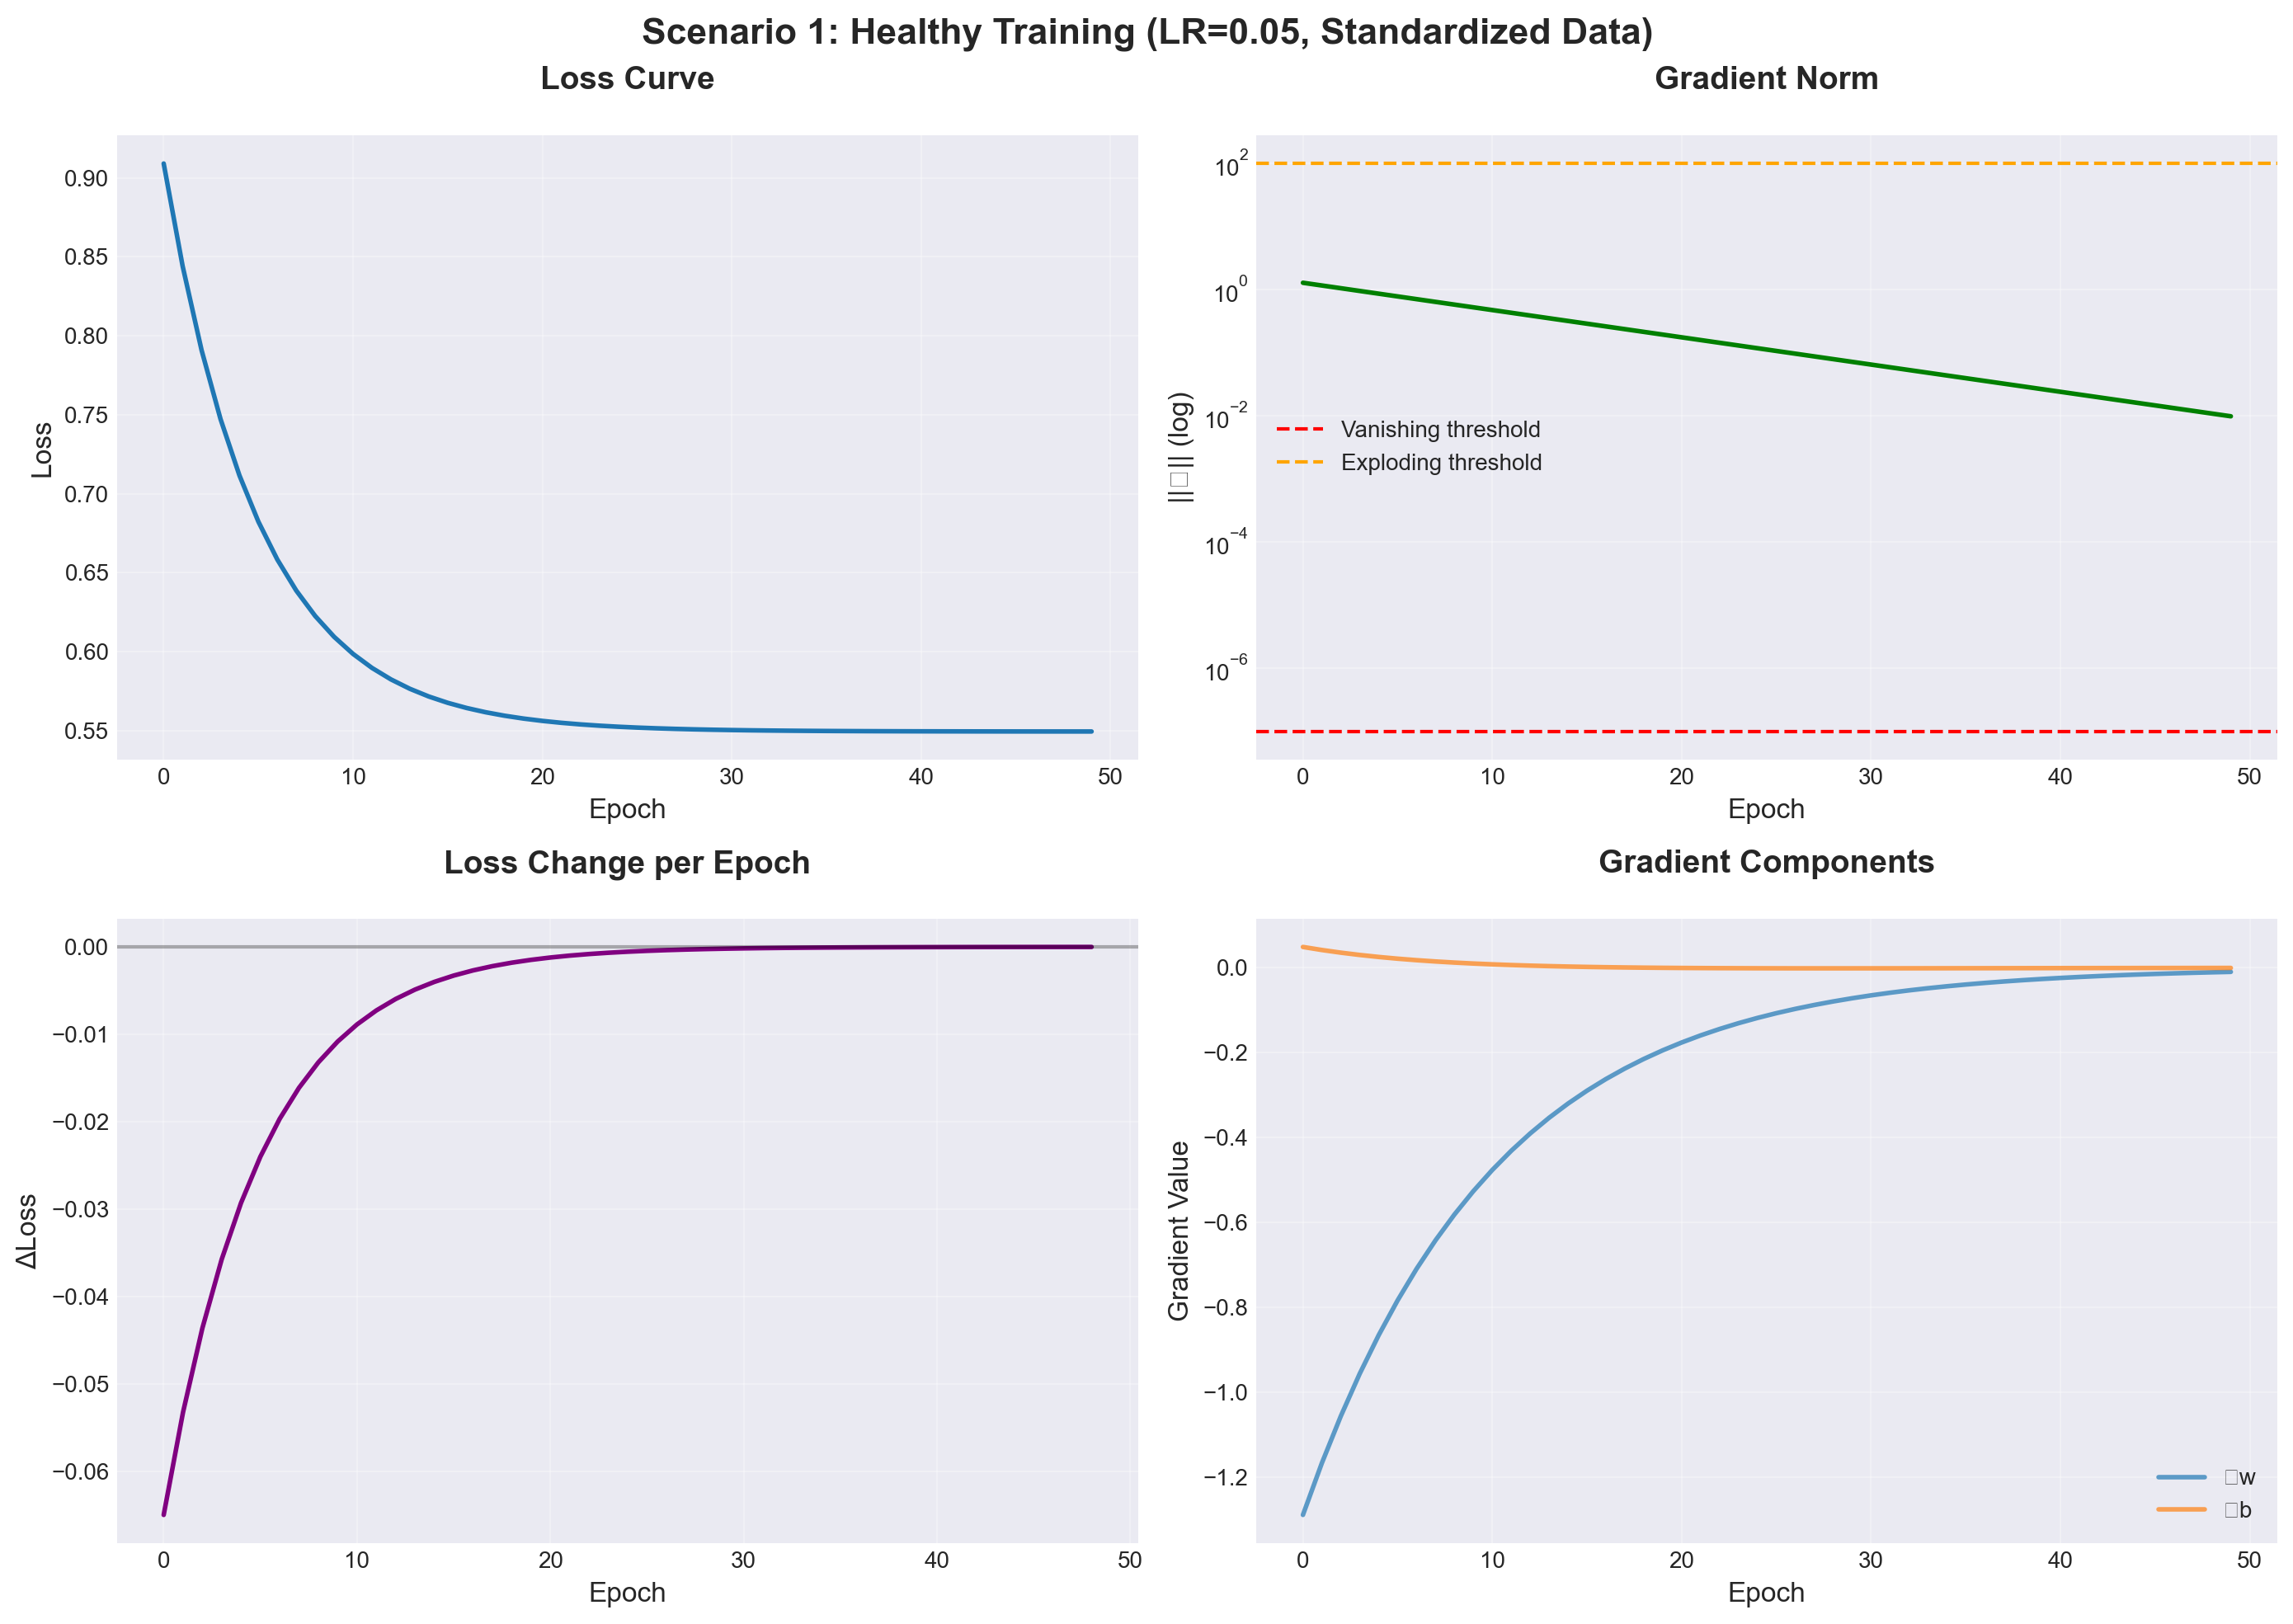

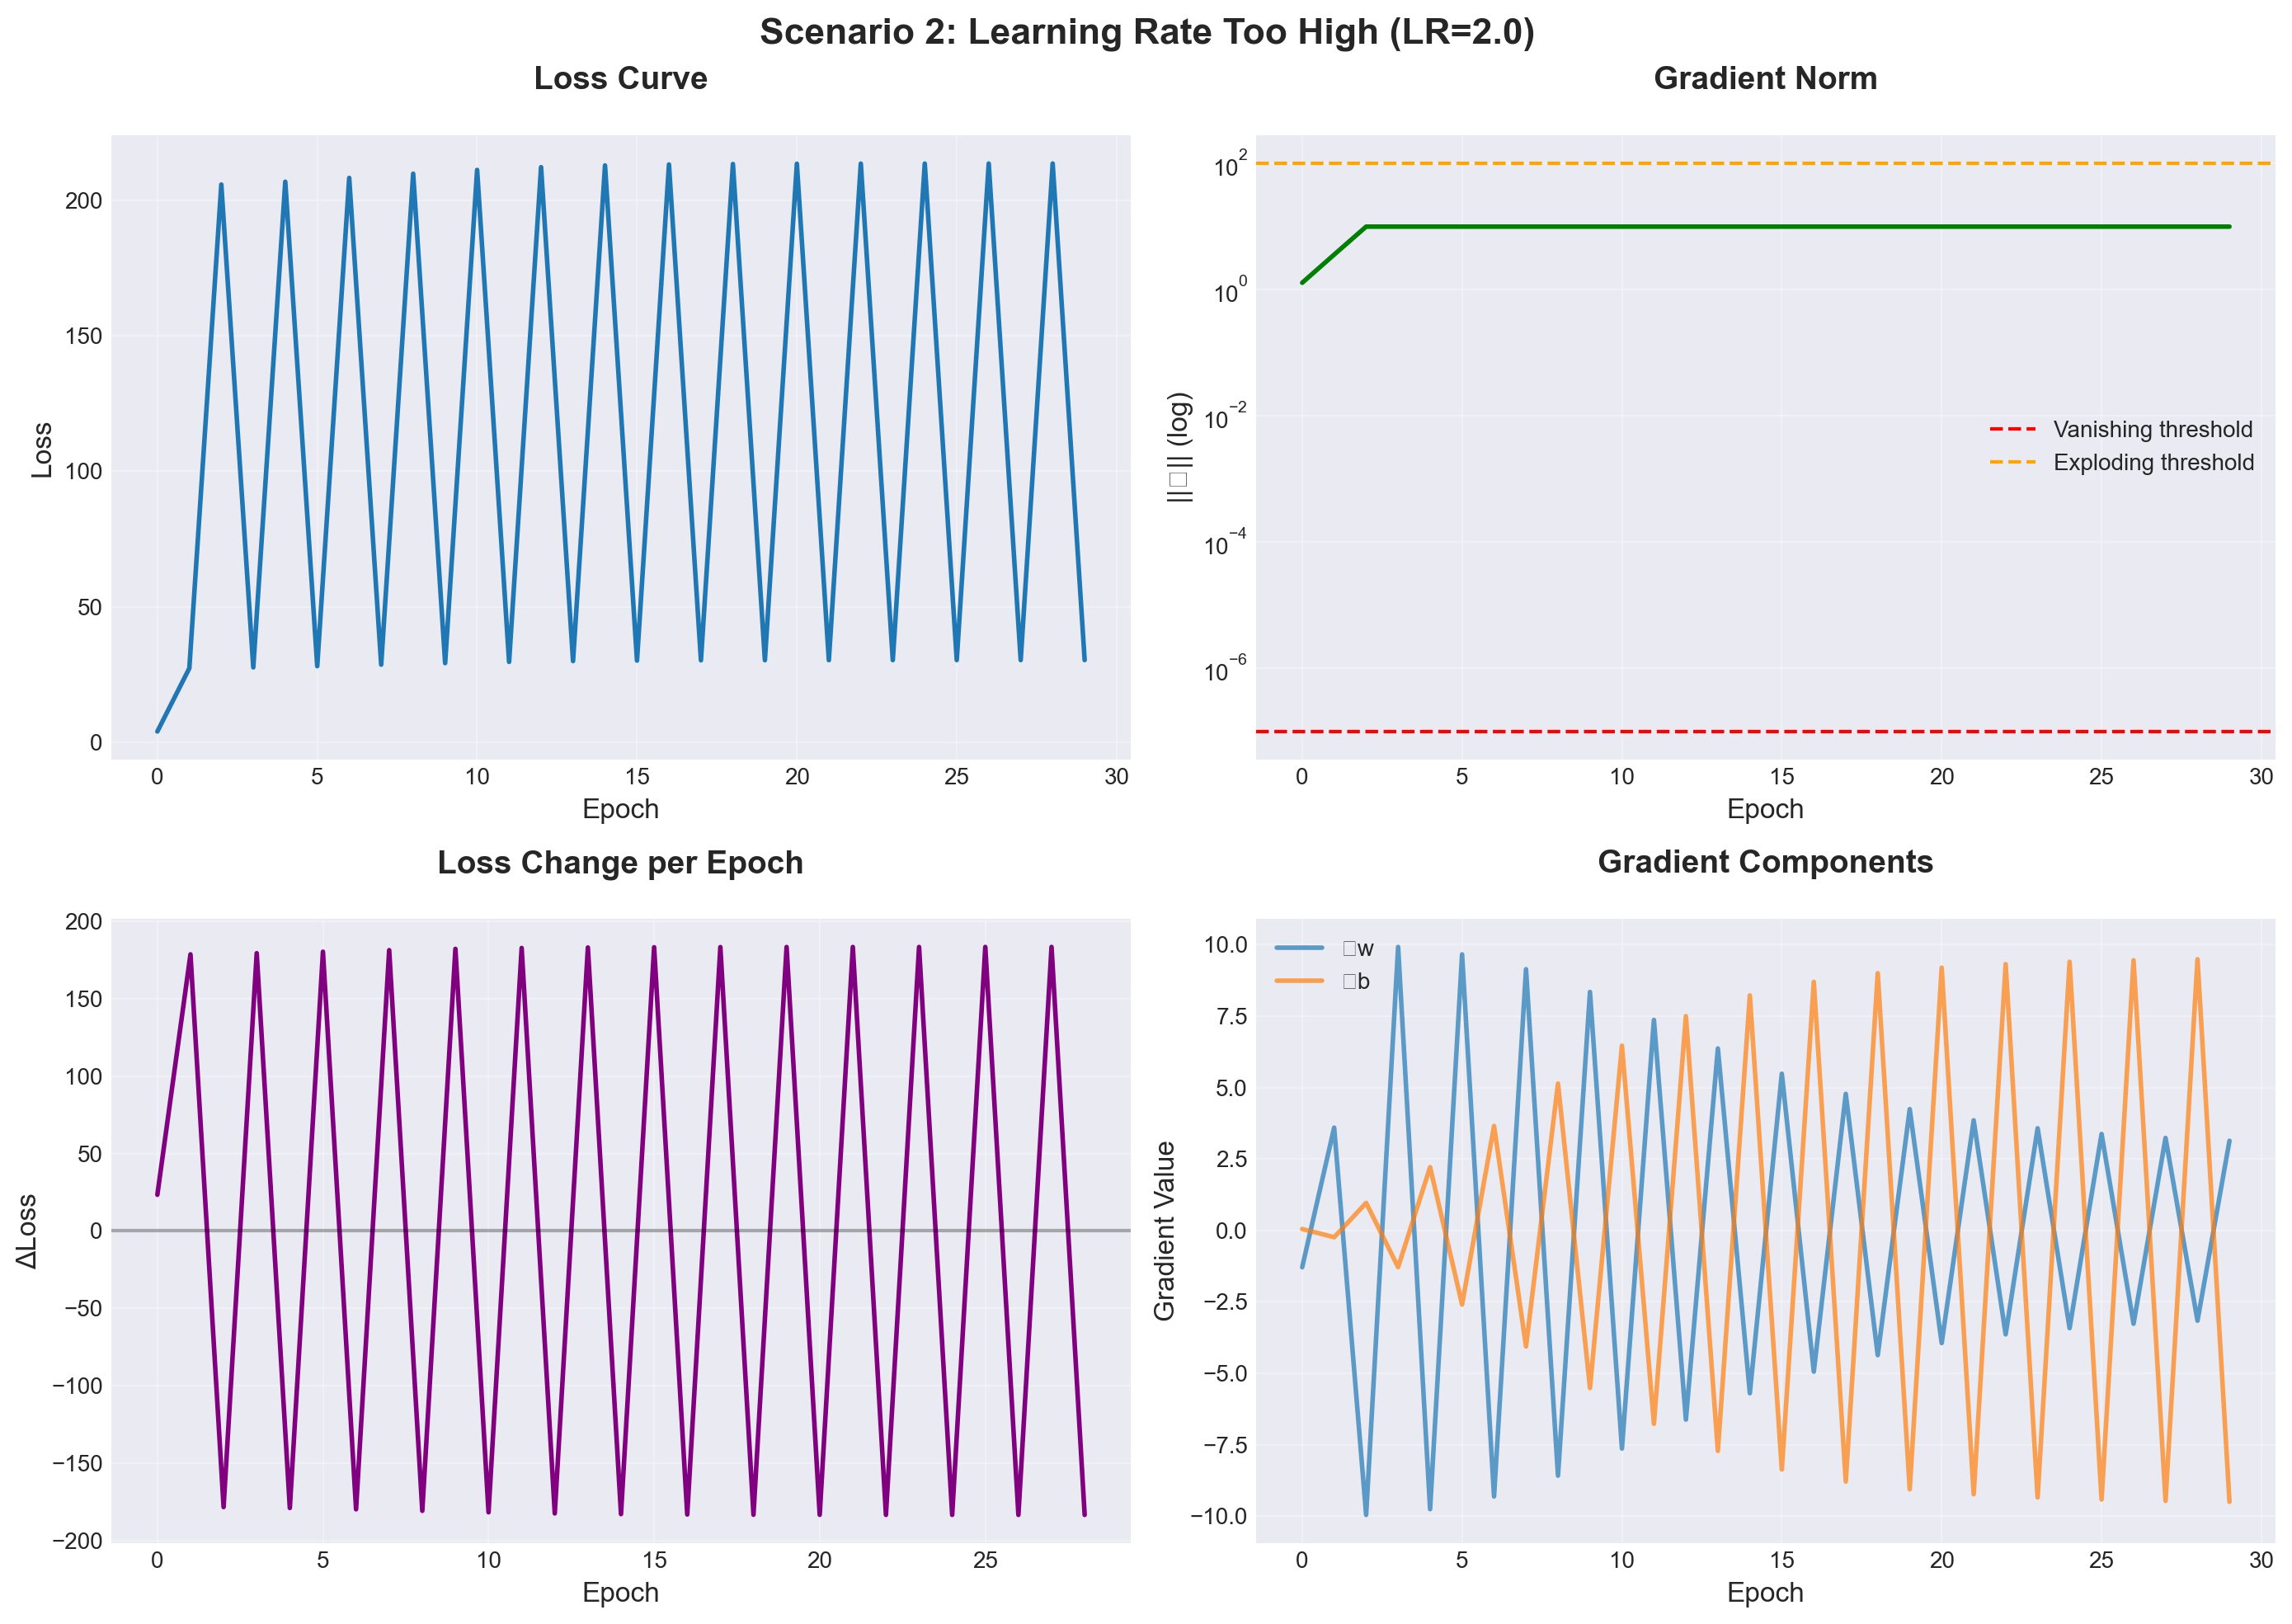

In [61]:
class GradientDiagnostic:
    """Tool for diagnosing gradient flow problems"""
    
    def __init__(self):
        self.problems_found = []
    
    def diagnose_training(self, losses, gradients, title="Training Diagnostics"):
        """Analyze training metrics for problems"""
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Loss curve analysis
        axes[0, 0].plot(losses, linewidth=2)
        style_plot(axes[0, 0], 'Loss Curve', 'Epoch', 'Loss')
        
        # Pattern detection
        if len(losses) > 10:
            recent = losses[-10:]
            if all(recent[i] >= recent[i-1] for i in range(1, len(recent))):
                axes[0, 0].text(0.5, 0.5, 'WARNING: Loss Increasing!', 
                              transform=axes[0, 0].transAxes,
                              fontsize=20, color='red', ha='center')
            elif np.std(recent) < 1e-6:
                axes[0, 0].text(0.5, 0.5, 'WARNING: Loss Plateaued!', 
                              transform=axes[0, 0].transAxes,
                              fontsize=20, color='orange', ha='center')
        
        # Gradient magnitude
        grad_norms = [np.sqrt(gw**2 + gb**2) for gw, gb in gradients]
        axes[0, 1].semilogy(grad_norms, linewidth=2, color='green')
        style_plot(axes[0, 1], 'Gradient Norm', 'Epoch', '||∇|| (log)')
        
        # Add diagnostic zones
        axes[0, 1].axhline(y=1e-7, color='red', linestyle='--', 
                          label='Vanishing threshold')
        axes[0, 1].axhline(y=100, color='orange', linestyle='--', 
                          label='Exploding threshold')
        axes[0, 1].legend()
        
        # Loss change rate
        if len(losses) > 1:
            loss_changes = np.diff(losses)
            axes[1, 0].plot(loss_changes, linewidth=2, color='purple')
            axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
            style_plot(axes[1, 0], 'Loss Change per Epoch', 'Epoch', 'ΔLoss')
        
        # Gradient components
        if gradients:
            grad_w = [gw for gw, gb in gradients]
            grad_b = [gb for gw, gb in gradients]
            axes[1, 1].plot(grad_w, label='∇w', linewidth=2, alpha=0.7)
            axes[1, 1].plot(grad_b, label='∇b', linewidth=2, alpha=0.7)
            style_plot(axes[1, 1], 'Gradient Components', 'Epoch', 'Gradient Value')
            axes[1, 1].legend()
        
        plt.suptitle(f'{title}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Detect problems
        self.problems_found = self._detect_problems(losses, grad_norms)
        return self.problems_found
    
    def _detect_problems(self, losses, grad_norms):
        """Detect training problems"""
        problems = []
        
        if grad_norms and len(grad_norms) > 10:
            if np.mean(grad_norms[-10:]) < 1e-7:
                problems.append("Vanishing Gradients")
            if np.mean(grad_norms[-10:]) > 100:
                problems.append("Exploding Gradients")
        
        if losses and len(losses) > 10:
            recent = losses[-10:]
            if all(recent[i] >= recent[i-1] * 0.99 for i in range(1, len(recent))):
                problems.append("Loss Increasing")
            elif np.std(recent) / np.mean(recent) < 1e-4:
                problems.append("Loss Plateaued")
        
        return problems

# Create real problematic training scenarios
diagnostic = GradientDiagnostic()

# Scenario 1: Healthy training with proper settings
gd_healthy = ManualGradientDescent(learning_rate=0.05)
for epoch in range(50):
    loss, grad_w, grad_b = gd_healthy.step(X_train, y_train)

problems_healthy = diagnostic.diagnose_training(
    gd_healthy.history['loss'], 
    list(zip(gd_healthy.history['grad_w'], gd_healthy.history['grad_b'])),
    title="Scenario 1: Healthy Training (LR=0.05, Standardized Data)"
)

# Scenario 2: Too high learning rate causing instability
gd_unstable = ManualGradientDescent(learning_rate=2.0)  # Very high LR
for epoch in range(30):
    loss, grad_w, grad_b = gd_unstable.step(X_train, y_train)
    if loss > 1e10:  # Stop if exploding
        break

problems_unstable = diagnostic.diagnose_training(
    gd_unstable.history['loss'], 
    list(zip(gd_unstable.history['grad_w'], gd_unstable.history['grad_b'])),
    title="Scenario 2: Learning Rate Too High (LR=2.0)"
)

# Scenario 3: Training on unstandardized data (the most common real problem)
# Use a subset of raw data to show the explosion
X_raw_subset = X_raw[:500].reshape(-1, 1)
y_raw_subset = y_raw[:500]

gd_unstandardized = ManualGradientDescent(learning_rate=0.01)  # Even small LR will fail
explosion_detected = False
for epoch in range(20):
    loss, grad_w, grad_b = gd_unstandardized.step(X_raw_subset, y_raw_subset)
    if loss > 1e10 or np.isnan(loss):
        explosion_detected = True
        break

if explosion_detected:
    problems_unstd = diagnostic.diagnose_training(
        gd_unstandardized.history['loss'], 
        list(zip(gd_unstandardized.history['grad_w'], gd_unstandardized.history['grad_b'])),
        title="Scenario 3: Unstandardized Data (MOST COMMON ERROR!)"
    )

### Best Practices Summary

## Optimization Best Practices

### 1. Data Preprocessing (CRITICAL!)
- **Always standardize your data** (mean=0, std=1)
- This is the #1 cause of gradient explosion
- Check data statistics before training
- Verify standardization worked: `assert abs(X.mean()) < 0.01`

### 2. Initialization
- Use Xavier/He initialization for weights
- Avoid initializing all parameters to zero
- Scale initialization with layer size
- Start with small random values for simple models

### 3. Learning Rate
- Start with standard values: 1e-3 for Adam, 1e-2 for SGD
- Use learning rate scheduling for long training
- Reduce learning rate when loss plateaus
- If loss explodes, first check data standardization, then reduce LR

### 4. Gradient Health
- Monitor gradient norms throughout training
- Implement gradient clipping as a safety net (typically max_norm=1.0)
- Check for NaN/Inf values regularly
- Watch for vanishing or exploding patterns

### 5. Debugging Tools
- Visualize loss curves at multiple scales (linear and log)
- Track gradient statistics (mean, std, max)
- Save checkpoints frequently
- Start with small, verifiable examples

### 6. Common Fixes

**Problem: Loss explodes (10^123!)**
- Solution: CHECK DATA STANDARDIZATION FIRST!
- Then: Reduce learning rate, add gradient clipping

**Problem: Loss plateaus early**
- Solution: Check gradients for vanishing, increase learning rate carefully

**Problem: Oscillating loss**
- Solution: Reduce learning rate, increase batch size, add momentum

**Problem: Very slow progress**
- Solution: Increase learning rate, check for vanishing gradients

## Conclusion

### What We've Learned

Through this journey from manual optimization to modern techniques, we've covered:

1. **Mathematical Framework**: Optimization as minimizing loss over parameters
2. **Gradient Descent**: The fundamental algorithm that powers machine learning
3. **Data Standardization**: Critical for preventing gradient explosion
4. **SGD Variants**: Trade-offs between accuracy and computational efficiency
5. **Modern Optimizers**: How momentum and adaptive learning rates improve convergence
6. **Debugging Skills**: Systematic approaches to diagnose and fix optimization problems

### Key Takeaways

**Data Preprocessing is Critical**: Always standardize your data - this prevents most gradient explosion issues.

**Start Simple**: Begin with basic gradient descent to build intuition before using complex optimizers.

**Learning Rate Matters**: It's the most important hyperparameter after data preprocessing.

**Monitor Everything**: Track losses, gradients, and parameters to catch problems early.

**Use Modern Tools**: Adam optimizer is a good default for prototyping.

**Debug Systematically**: Most optimization problems have known solutions.


### Thank You!

Happy Optimizing!